In [ ]:
!python3 --version

Python 3.11.13


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<ipython-input-3-7569343e0ea3>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset.loc[:, 'pkt_rate'] = dataset['pktcount'] / dataset['dur']
<ipython-input-3-7569343e0ea3>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset.loc[:, 'byte_rate'] = dataset['bytecount'] / dataset['dur']
<ipython-input-3-7569343e0ea3>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

Detected DDoS Events:
                      dt  switch        src       dst  pktcount  bytecount  \
5834 1970-01-01 03:15:55       3  10.0.0.10  10.0.0.8    109997    1000000   
5835 1970-01-01 03:15:55       3  10.0.0.10  10.0.0.8    109997    1000000   
5836 1970-01-01 03:15:55       3  10.0.0.10  10.0.0.8    109997    1000000   
5837 1970-01-01 03:15:55       3  10.0.0.10  10.0.0.8    109997    1000000   
5838 1970-01-01 03:11:55       3   10.0.0.1  10.0.0.8     85573    1000000   

      dur   dur_nsec       tot_dur  flows  ...    pkt_rate      byte_rate  \
5834  380  560000000  3.810000e+11      2  ...  289.465789  301623.352632   
5835  380  560000000  3.810000e+11      2  ...  289.465789  301623.352632   
5836  380  560000000  3.810000e+11      2  ...  289.465789  301623.352632   
5837  380  560000000  3.810000e+11      2  ...  289.465789  301623.352632   
5838  190  299000000  1.900000e+11      5  ...  450.384211  480109.568421   

      flow_rate  rolling_pkt_rate  rolling_byt

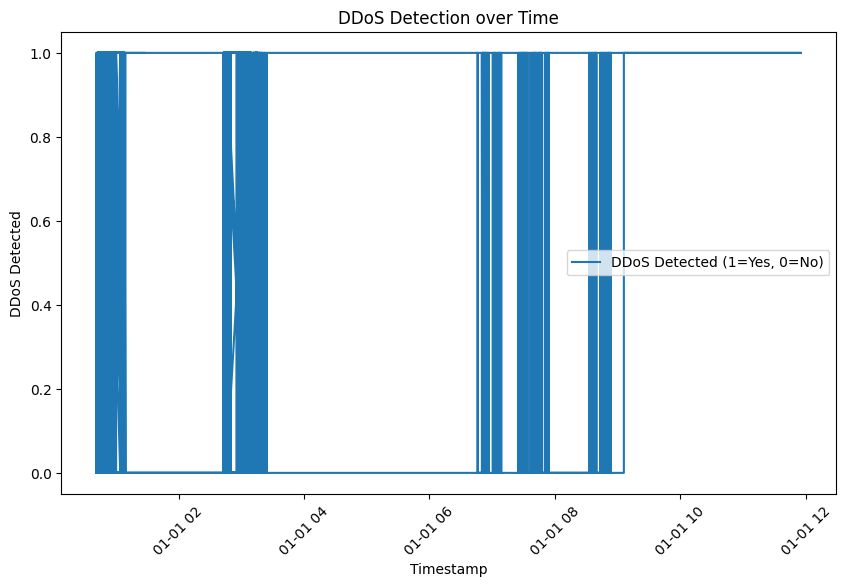

✅ Detected DDoS events saved as 'detected_ddos_events.csv'.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import RobustScaler
from scipy.stats import zscore
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report

# Load the dataset
file_path = '/content/drive/MyDrive/Colab Notebooks/tools & technique/dataset/dataset_sdn.csv'
dataset = pd.read_csv(file_path)

### --------------------- Step 1: Data Preprocessing --------------------- ###
# Convert timestamp column 'dt' to datetime format (if exists)
dataset['dt'] = pd.to_datetime(dataset['dt'], unit='s')

# Handle missing values
numeric_columns = dataset.select_dtypes(include=[np.number]).columns
dataset.loc[:, numeric_columns] = dataset[numeric_columns].fillna(dataset[numeric_columns].mean())

non_numeric_columns = dataset.select_dtypes(exclude=[np.number]).columns
dataset.loc[:, non_numeric_columns] = dataset[non_numeric_columns].fillna('unknown')

# Drop duplicates
dataset = dataset.drop_duplicates()

### --------------------- Step 2: Feature Engineering --------------------- ###
# Step 2: Feature Engineering
dataset.loc[:, 'pkt_rate'] = dataset['pktcount'] / dataset['dur']
dataset.loc[:, 'byte_rate'] = dataset['bytecount'] / dataset['dur']
dataset.loc[:, 'flow_rate'] = dataset['flows'] / dataset['dur']

# Add rolling statistics features
dataset.loc[:, 'rolling_pkt_rate'] = dataset['pkt_rate'].rolling(window=10).mean()
dataset.loc[:, 'rolling_byte_rate'] = dataset['byte_rate'].rolling(window=10).mean()

### --------------------- Step 3: Handle Extreme Values (Inf and NaN) --------------------- ###
features = ['pktcount', 'bytecount', 'flows', 'pkt_rate', 'byte_rate', 'flow_rate']
dataset.loc[:, features] = dataset[features].replace([np.inf, -np.inf], np.nan).fillna(dataset[features].max())
dataset.loc[:, features] = dataset[features].clip(upper=1e6)

# Ensure there are no NaN or Inf values left
assert dataset[features].isna().sum().sum() == 0, "There are still NaN values in the dataset"

### --------------------- Step 4: Scaling the Data --------------------- ###
scaler = RobustScaler()
X_scaled = scaler.fit_transform(dataset[features])

### --------------------- Step 5: Anomaly Detection Using Z-Scores --------------------- ###
dataset.loc[:, 'z_pkt_rate'] = zscore(dataset['pkt_rate'])
dataset.loc[:, 'z_byte_rate'] = zscore(dataset['byte_rate'])
dataset.loc[:, 'potential_ddos_pkt'] = dataset['z_pkt_rate'].apply(lambda x: 1 if abs(x) > 3 else 0)
dataset.loc[:, 'potential_ddos_byte'] = dataset['z_byte_rate'].apply(lambda x: 1 if abs(x) > 3 else 0)

### --------------------- Step 6: Handling Class Imbalance (SMOTE) --------------------- ###
X = dataset[features]
y = dataset['potential_ddos_pkt'] | dataset['potential_ddos_byte']
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

### --------------------- Step 7: Training Multiple Models for Anomaly Detection --------------------- ###
# Isolation Forest
iso_forest = IsolationForest(n_estimators=100, contamination=0.01, random_state=42)
iso_forest.fit(X_resampled)
y_pred_iso = iso_forest.predict(X_resampled)

# One-Class SVM
one_class_svm = OneClassSVM(nu=0.01, kernel="rbf", gamma="scale")
one_class_svm.fit(X_resampled)
y_pred_svm = one_class_svm.predict(X_resampled)

# Local Outlier Factor (LOF)
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.01)
y_pred_lof = lof.fit_predict(X_resampled)

# Convert model output: -1 = anomaly, 1 = normal
y_pred_iso = np.where(y_pred_iso == -1, 1, 0)
y_pred_svm = np.where(y_pred_svm == -1, 1, 0)
y_pred_lof = np.where(y_pred_lof == -1, 1, 0)

### --------------------- Step 8: Combine Anomaly Flags and Detect DDoS Events --------------------- ###
final_detection = y_pred_iso | y_pred_svm | y_pred_lof | y_resampled

# Show the detected DDoS events
ddos_events = dataset.iloc[:len(y_resampled)]  # Make sure we are selecting the same number of rows as in the resampled data
ddos_events['final_detection'] = final_detection
ddos_events = ddos_events[ddos_events['final_detection'] == 1]

# Display detected DDoS events
print("Detected DDoS Events:")
print(ddos_events.head())

### --------------------- Step 9: Evaluate the Model Performance --------------------- ###
print("Model Evaluation Metrics:")
print(classification_report(y_resampled, final_detection))

### --------------------- Step 10: Plot DDoS Detection over Time --------------------- ###
# We now use the resampled data `y_resampled` and corresponding indices
resampled_index = np.linspace(0, len(dataset) - 1, num=len(y_resampled)).astype(int)
resampled_index = np.clip(resampled_index, 0, len(dataset) - 1)
resampled_dt = dataset.iloc[resampled_index]['dt'].reset_index(drop=True)

# Ensure `final_detection` has the same shape
final_detection = final_detection[:len(resampled_dt)]

# Now plot the graph
plt.figure(figsize=(10, 6))
plt.plot(resampled_dt, final_detection, label='DDoS Detected (1=Yes, 0=No)')
plt.title("DDoS Detection over Time")
plt.xlabel("Timestamp")
plt.ylabel("DDoS Detected")
plt.legend()
plt.xticks(rotation=45)
plt.show()

### --------------------- Optional: Save the Detected DDoS Events to a CSV --------------------- ###
ddos_events.to_csv('detected_ddos_events.csv', index=False)
print("✅ Detected DDoS events saved as 'detected_ddos_events.csv'.")


✅ Detected DDoS events saved as 'detected_ddos_attacks.csv'.


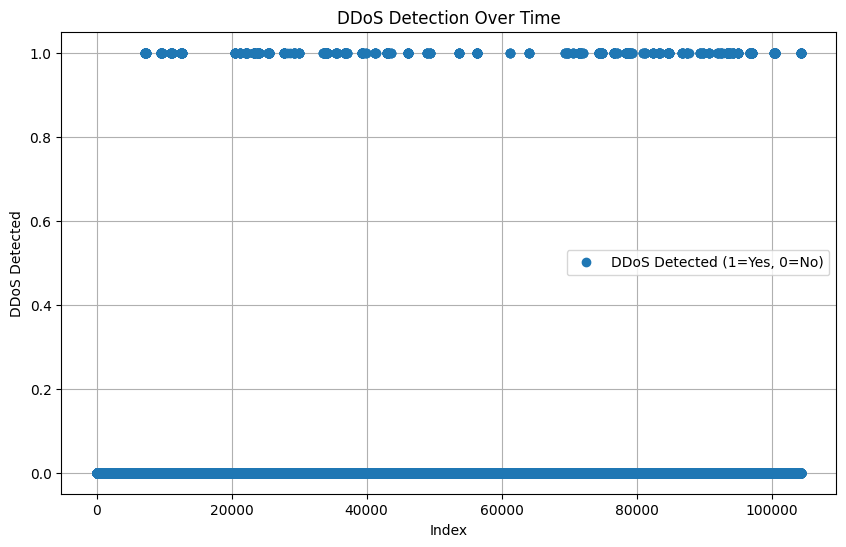

In [ ]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from scipy.stats import zscore

# Load the dataset
file_path = "/content/drive/MyDrive/Colab Notebooks/tools & technique/dataset/dataset_sdn.csv"  # Update the correct path
dataset = pd.read_csv(file_path)

### --------------------- Step 1: Data Preprocessing --------------------- ###
# Convert timestamp column 'dt' to datetime format (if exists)
if 'dt' in dataset.columns:
    dataset['dt'] = pd.to_datetime(dataset['dt'], unit='s', errors='coerce')

# Select only numeric columns (remove non-numeric like IPs & Protocols)
numeric_cols = dataset.select_dtypes(include=[np.number]).columns
dataset = dataset[numeric_cols]

# Remove duplicate and missing values
dataset.dropna(inplace=True)  # Drop rows with missing values
dataset.drop_duplicates(inplace=True)  # Drop duplicate rows

# Fixing zero division errors by replacing 0 in 'dur' column with NaN
if 'dur' in dataset.columns:
    dataset.loc[dataset['dur'] == 0, 'dur'] = np.nan  # Correct way to modify DataFrame
    dataset.dropna(subset=['dur'], inplace=True)  # Drop rows where 'dur' is NaN

### --------------------- Step 2: Feature Engineering --------------------- ###
# Compute network traffic rates
dataset['pkt_rate'] = dataset['pktcount'] / dataset['dur']
dataset['byte_rate'] = dataset['bytecount'] / dataset['dur']
dataset['flow_rate'] = dataset['flows'] / dataset['dur']

# Replace infinite values with NaN and then fill them with median values
dataset.replace([np.inf, -np.inf], np.nan, inplace=True)
dataset.fillna(dataset.median(numeric_only=True), inplace=True)

### --------------------- Step 3: Statistical Analysis (Z-score) --------------------- ###
# Calculate Z-score to detect outliers in packet & byte rates
dataset['z_pkt_rate'] = zscore(dataset['pkt_rate'])
dataset['z_byte_rate'] = zscore(dataset['byte_rate'])

# Flag potential DDoS based on Z-score threshold (absolute value > 3)
dataset['potential_ddos_pkt'] = (dataset['z_pkt_rate'].abs() > 3).astype(int)
dataset['potential_ddos_byte'] = (dataset['z_byte_rate'].abs() > 3).astype(int)

### --------------------- Step 4: Machine Learning Model (Isolation Forest) --------------------- ###
# Define features to be used for anomaly detection
features = ['pkt_rate', 'byte_rate', 'flow_rate']
X = dataset[features]

# Standardize the features (important for ML models)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train the Isolation Forest model (detects anomalies)
iso_forest = IsolationForest(contamination=0.01, random_state=42)  # 1% contamination assumed
dataset['ddos_anomaly'] = iso_forest.fit_predict(X_scaled)

# Convert -1 (anomalies) to 1 for easier understanding
dataset['ddos_anomaly'] = (dataset['ddos_anomaly'] == -1).astype(int)

### --------------------- Step 5: Traffic Flow Monitoring --------------------- ###
# Identify high flow rate sessions (top 1% of flow rates)
high_flow_sessions = dataset[dataset['flow_rate'] > dataset['flow_rate'].quantile(0.99)]

# Identify high packet count sessions (top 1%)
pkt_threshold = dataset['pktcount'].quantile(0.99)
high_pkt_sessions = dataset[dataset['pktcount'] > pkt_threshold]

### --------------------- Step 6: Final DDoS Detection --------------------- ###
# Combine multiple indicators for robust DDoS detection
dataset['final_ddos_detection'] = (
    dataset['ddos_anomaly'] | dataset['potential_ddos_pkt'] | dataset['potential_ddos_byte']
)

# Extract only detected DDoS attack instances
ddos_events = dataset[dataset['final_ddos_detection'] == 1]

### --------------------- Step 7: Save & Display Results --------------------- ###
# Save detected DDoS attacks to CSV for review
ddos_events.to_csv("/content/detected_ddos_attacks.csv", index=False)
print("✅ Detected DDoS events saved as 'detected_ddos_attacks.csv'.")

# Plot the DDoS detection results over time
plt.figure(figsize=(10, 6))
plt.plot(dataset.index, dataset['final_ddos_detection'], label='DDoS Detected (1=Yes, 0=No)', marker='o', linestyle='')
plt.title("DDoS Detection Over Time")
plt.xlabel("Index")
plt.ylabel("DDoS Detected")
plt.legend()
plt.grid()
plt.show()


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, LSTM, Flatten, Dropout
import matplotlib.pyplot as plt
import seaborn as sns
!pip install seaborn

In [ ]:
# Load and preprocess the dataset
file_path = '/content/drive/MyDrive/Colab Notebooks/tools & technique/dataset/dataset_sdn.csv'
data = pd.read_csv(file_path)

In [ ]:
print(data.head())

      dt  switch       src       dst  pktcount  bytecount  dur   dur_nsec  \
0  11425       1  10.0.0.1  10.0.0.8     45304   48294064  100  716000000   
1  11605       1  10.0.0.1  10.0.0.8    126395  134737070  280  734000000   
2  11425       1  10.0.0.2  10.0.0.8     90333   96294978  200  744000000   
3  11425       1  10.0.0.2  10.0.0.8     90333   96294978  200  744000000   
4  11425       1  10.0.0.2  10.0.0.8     90333   96294978  200  744000000   

        tot_dur  flows  ...  pktrate  Pairflow  Protocol  port_no   tx_bytes  \
0  1.010000e+11      3  ...      451         0       UDP        3  143928631   
1  2.810000e+11      2  ...      451         0       UDP        4       3842   
2  2.010000e+11      3  ...      451         0       UDP        1       3795   
3  2.010000e+11      3  ...      451         0       UDP        2       3688   
4  2.010000e+11      3  ...      451         0       UDP        3       3413   

  rx_bytes  tx_kbps  rx_kbps  tot_kbps  label  
0     39

In [ ]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104345 entries, 0 to 104344
Data columns (total 23 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   dt           104345 non-null  int64  
 1   switch       104345 non-null  int64  
 2   src          104345 non-null  object 
 3   dst          104345 non-null  object 
 4   pktcount     104345 non-null  int64  
 5   bytecount    104345 non-null  int64  
 6   dur          104345 non-null  int64  
 7   dur_nsec     104345 non-null  int64  
 8   tot_dur      104345 non-null  float64
 9   flows        104345 non-null  int64  
 10  packetins    104345 non-null  int64  
 11  pktperflow   104345 non-null  int64  
 12  byteperflow  104345 non-null  int64  
 13  pktrate      104345 non-null  int64  
 14  Pairflow     104345 non-null  int64  
 15  Protocol     104345 non-null  object 
 16  port_no      104345 non-null  int64  
 17  tx_bytes     104345 non-null  int64  
 18  rx_bytes     104345 non-

In [ ]:
print(data.describe())

                  dt         switch       pktcount     bytecount  \
count  104345.000000  104345.000000  104345.000000  1.043450e+05   
mean    17927.514169       4.214260   52860.954746  3.818660e+07   
std     11977.642655       1.956327   52023.241460  4.877748e+07   
min      2488.000000       1.000000       0.000000  0.000000e+00   
25%      7098.000000       3.000000     808.000000  7.957600e+04   
50%     11905.000000       4.000000   42828.000000  6.471930e+06   
75%     29952.000000       5.000000   94796.000000  7.620354e+07   
max     42935.000000      10.000000  260006.000000  1.471280e+08   

                 dur      dur_nsec       tot_dur          flows  \
count  104345.000000  1.043450e+05  1.043450e+05  104345.000000   
mean      321.497398  4.613880e+08  3.218865e+11       5.654234   
std       283.518232  2.770019e+08  2.834029e+11       2.950036   
min         0.000000  0.000000e+00  0.000000e+00       2.000000   
25%       127.000000  2.340000e+08  1.270000e+11    

In [ ]:
print(data.isnull().sum())  # Check missing values
data = data.dropna()  # Drop rows with missing values


dt               0
switch           0
src              0
dst              0
pktcount         0
bytecount        0
dur              0
dur_nsec         0
tot_dur          0
flows            0
packetins        0
pktperflow       0
byteperflow      0
pktrate          0
Pairflow         0
Protocol         0
port_no          0
tx_bytes         0
rx_bytes         0
tx_kbps          0
rx_kbps        506
tot_kbps       506
label            0
dtype: int64


In [ ]:
data['Protocol'] = data['Protocol'].astype('category').cat.codes  # Convert to numeric


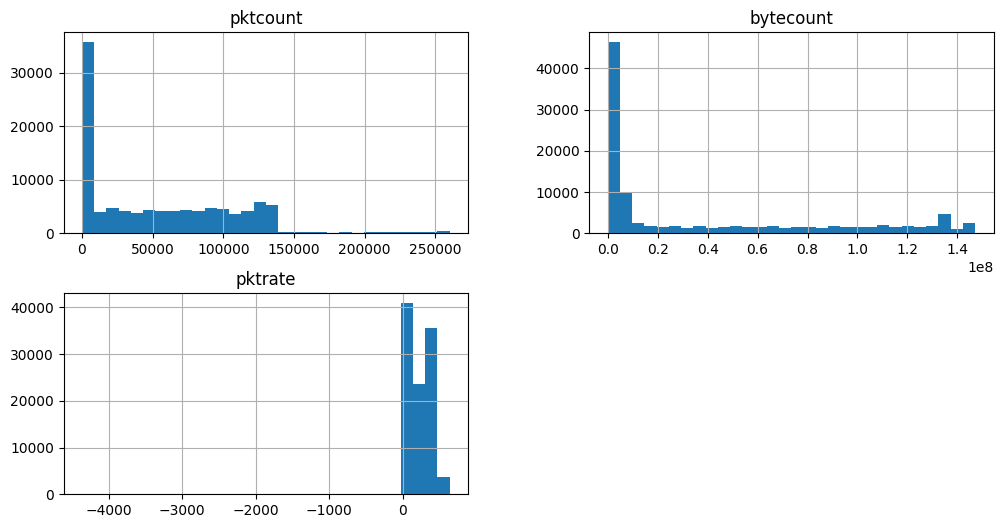

In [ ]:
data[['pktcount', 'bytecount', 'pktrate']].hist(bins=30, figsize=(12, 6))
plt.show()


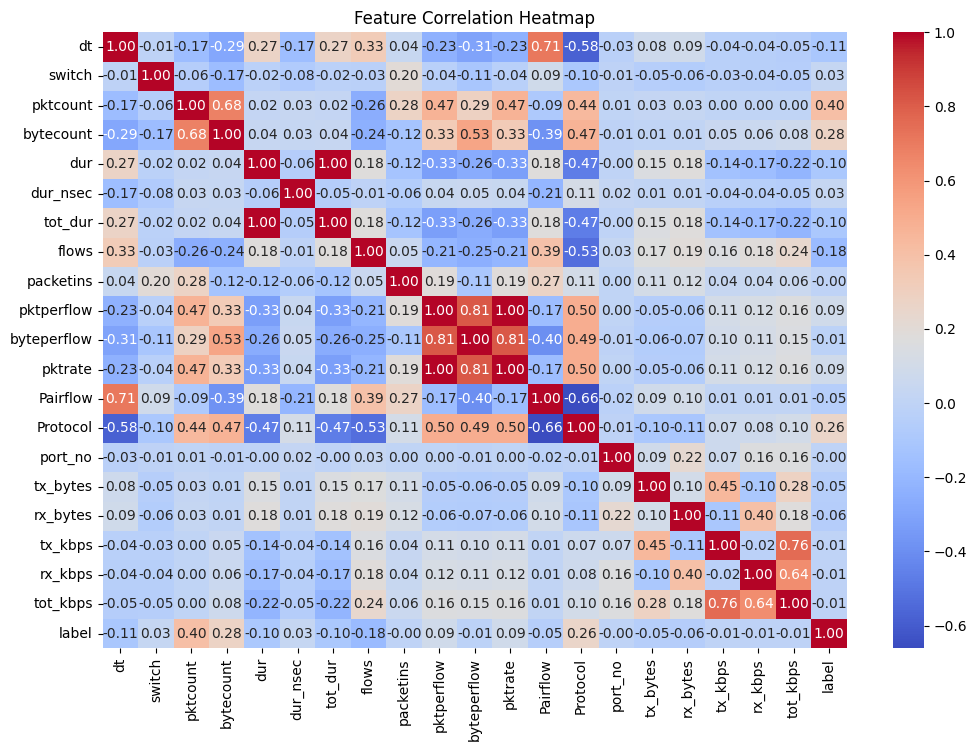

In [ ]:
numerical_data = data.select_dtypes(include=np.number) # Select only numerical columns for correlation
corr = numerical_data.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation Heatmap')
plt.show()


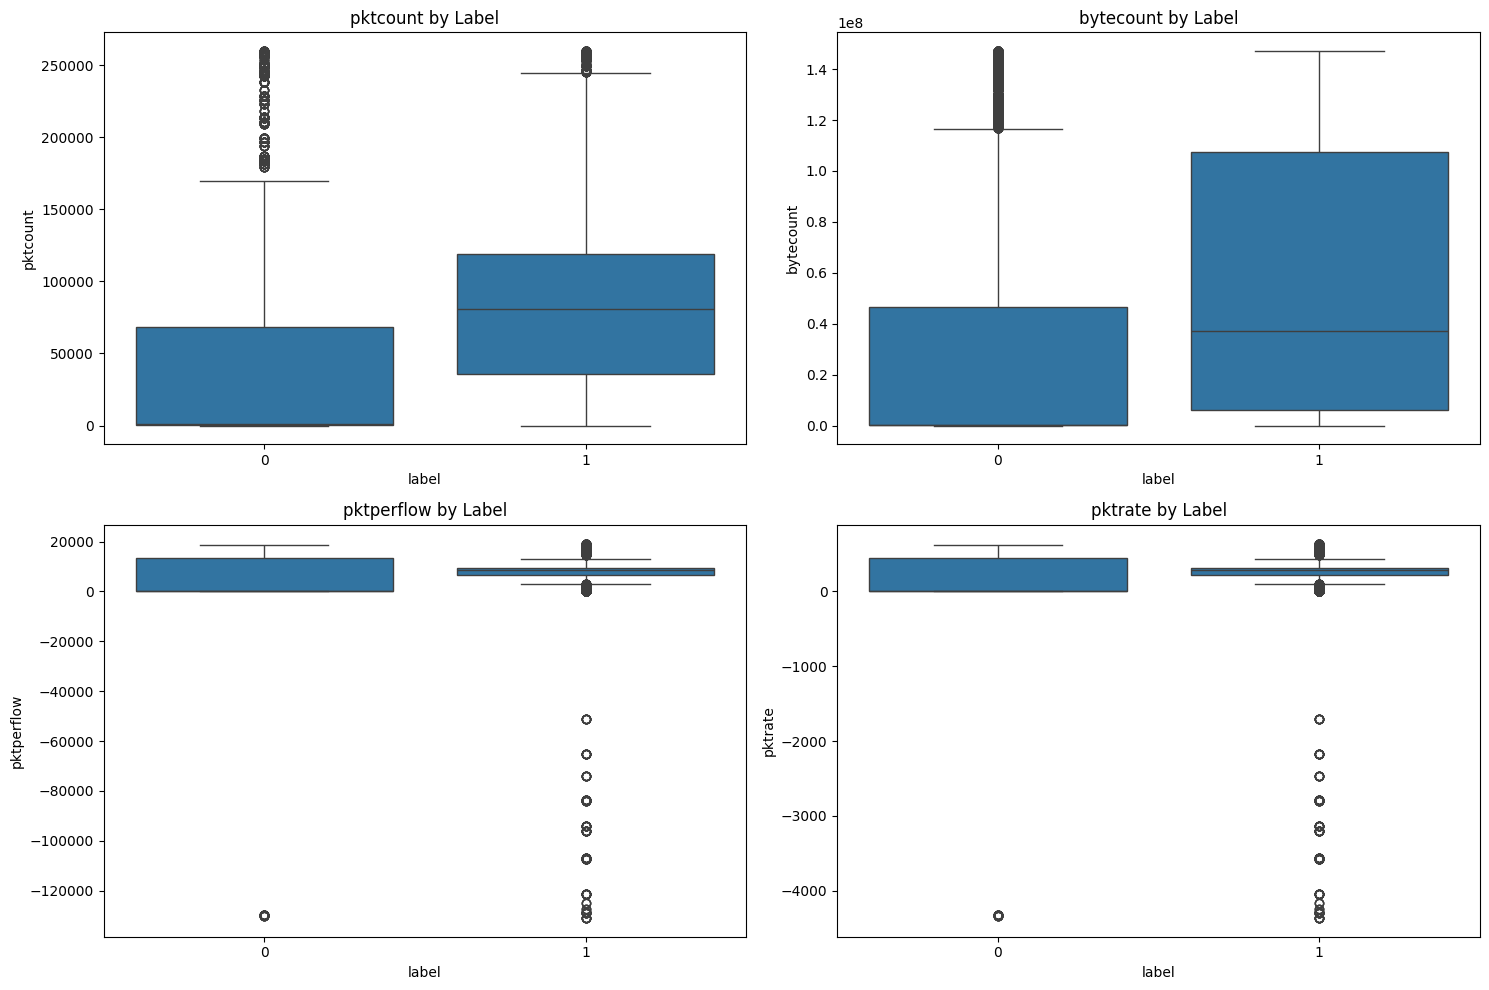

In [ ]:
plt.figure(figsize=(15, 10))
for i, col in enumerate(['pktcount', 'bytecount', 'pktperflow', 'pktrate']):
    plt.subplot(2, 2, i + 1)
    sns.boxplot(x='label', y=col, data=data)
    plt.title(f'{col} by Label')
plt.tight_layout()
plt.show()

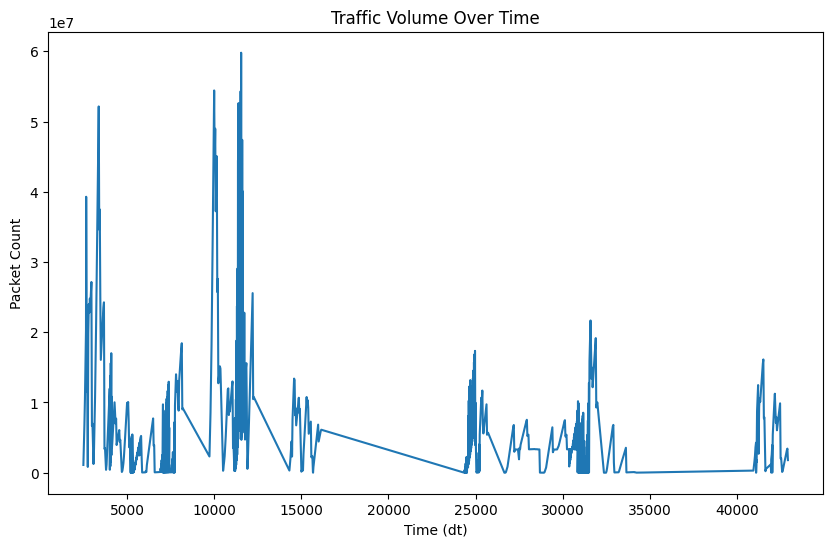

In [ ]:
plt.figure(figsize=(10, 6))
data.groupby('dt')['pktcount'].sum().plot(kind='line')
plt.title('Traffic Volume Over Time')
plt.xlabel('Time (dt)')
plt.ylabel('Packet Count')
plt.show()


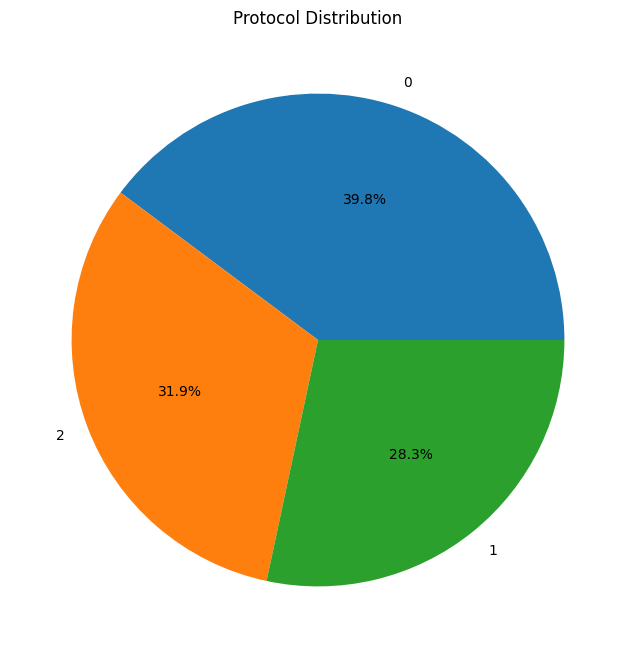

In [ ]:
protocol_counts = data['Protocol'].value_counts()
protocol_counts.plot(kind='pie', autopct='%1.1f%%', figsize=(8, 8))
plt.title('Protocol Distribution')
plt.ylabel('')
plt.show()

Available columns: ['dt', 'switch', 'src', 'dst', 'pktcount', 'bytecount', 'dur', 'dur_nsec', 'tot_dur', 'flows', 'packetins', 'pktperflow', 'byteperflow', 'pktrate', 'Pairflow', 'Protocol', 'port_no', 'tx_bytes', 'rx_bytes', 'tx_kbps', 'rx_kbps', 'tot_kbps', 'label']
Training Set Class Distribution:
 label
0    44334
1    28353
Name: count, dtype: int64
Test Set Class Distribution:
 label
0    19001
1    12151
Name: count, dtype: int64


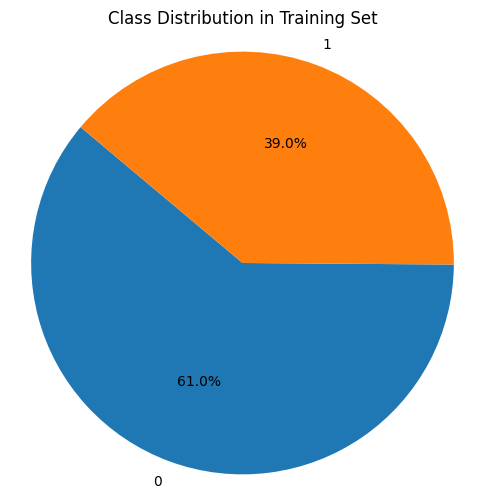

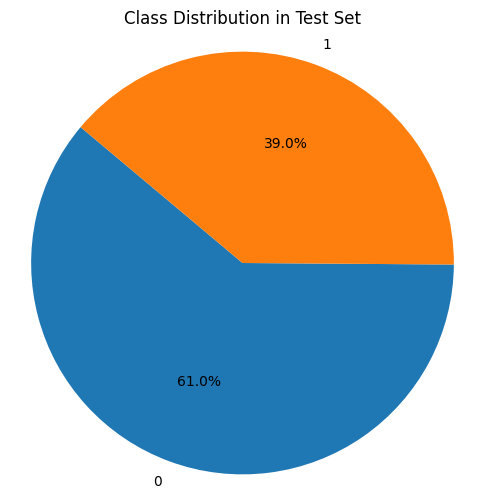

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Step 1: Load the dataset
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/tools & technique/dataset/dataset_sdn.csv')

# Step 1.5: Inspect available columns
print("Available columns:", df.columns.tolist())

# Step 2: Drop incomplete or corrupted records
df_clean = df.dropna()

# Step 2.5: Adjust this based on available column names
# Example fallback for safety
duration_col = 'duration' if 'duration' in df_clean.columns else df_clean.columns[0]
bytes_col = 'bytes' if 'bytes' in df_clean.columns else df_clean.columns[1]

# Step 3: Drop rows with non-realistic values
try:
    df_clean = df_clean[
        (df_clean[duration_col] >= 0) &
        (df_clean[bytes_col] >= 0)
    ]
except Exception as e:
    print(f"Skipping range filtering due to error: {e}")

# Step 4: Encode labels
label_col = 'label'
if label_col not in df_clean.columns:
    raise ValueError(f"'{label_col}' column is missing in the dataset.")

label_encoder = LabelEncoder()
df_clean['label_encoded'] = label_encoder.fit_transform(df_clean[label_col])

# Step 5: Stratified sampling
X = df_clean.drop(columns=[label_col, 'label_encoded'])
y = df_clean['label_encoded']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    stratify=y,
    random_state=42
)

# Recombine for inspection
train_df = X_train.copy()
train_df['label'] = label_encoder.inverse_transform(y_train)

test_df = X_test.copy()
test_df['label'] = label_encoder.inverse_transform(y_test)

# Final counts
print("Training Set Class Distribution:\n", train_df['label'].value_counts())
print("Test Set Class Distribution:\n", test_df['label'].value_counts())


import matplotlib.pyplot as plt

# Pie chart for training set
train_counts = train_df['label'].value_counts()
plt.figure(figsize=(6, 6))
plt.pie(train_counts, labels=train_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Class Distribution in Training Set')
plt.axis('equal')
plt.show()

# Pie chart for test set
test_counts = test_df['label'].value_counts()
plt.figure(figsize=(6, 6))
plt.pie(test_counts, labels=test_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Class Distribution in Test Set')
plt.axis('equal')
plt.show()


label
0    63561
1    40784
Name: count, dtype: int64


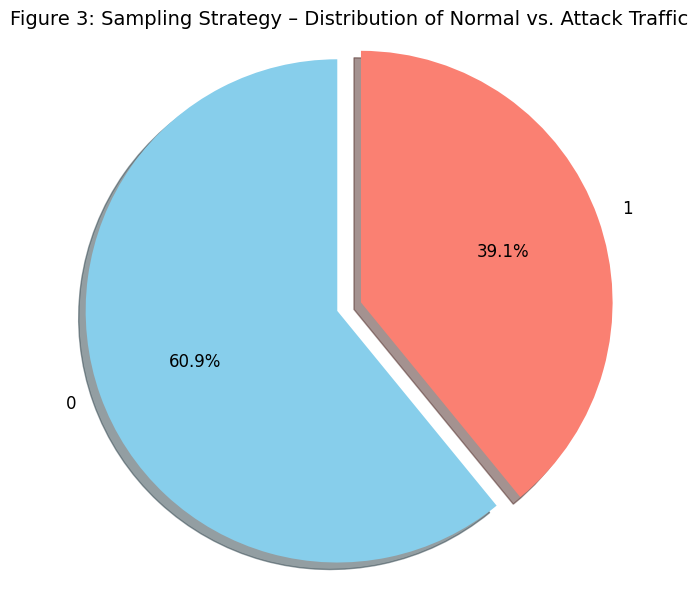

Pie chart saved to: /content/drive/MyDrive/Colab Notebooks/tools & technique/graphs_results/sampling_strategy_pie_chart.png


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Step 1: Load the dataset
file_path = '/content/drive/MyDrive/Colab Notebooks/tools & technique/dataset/dataset_sdn.csv'
dataset = pd.read_csv(file_path)

# Step 2: Inspect and count labels (update 'label' to your actual column name)
label_column = 'label'  # Replace with the actual column name if different
label_counts = dataset[label_column].value_counts()

# Check if labels contain 'Normal' and 'DDoS' or similar
print(label_counts)  # Optional: see exact class names

# Step 3: Prepare pie chart values
labels = label_counts.index.tolist()
sizes = label_counts.values.tolist()
colors = ['skyblue', 'salmon', 'lightgreen', 'orange'][:len(labels)]  # up to 4 classes
explode = [0.05] * len(labels)

# Step 4: Create and save the pie chart
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%',
        startangle=90, explode=explode, shadow=True, textprops={'fontsize': 12})
plt.title("Figure 3: Sampling Strategy – Distribution of Normal vs. Attack Traffic", fontsize=14)
plt.axis('equal')
plt.tight_layout()

# Step 5: Save the image
output_path = "/content/drive/MyDrive/Colab Notebooks/tools & technique/graphs_results"
os.makedirs(output_path, exist_ok=True)
output_file = os.path.join(output_path, "sampling_strategy_pie_chart.png")
plt.savefig(output_file, dpi=300)
plt.show()

print(f"Pie chart saved to: {output_file}")


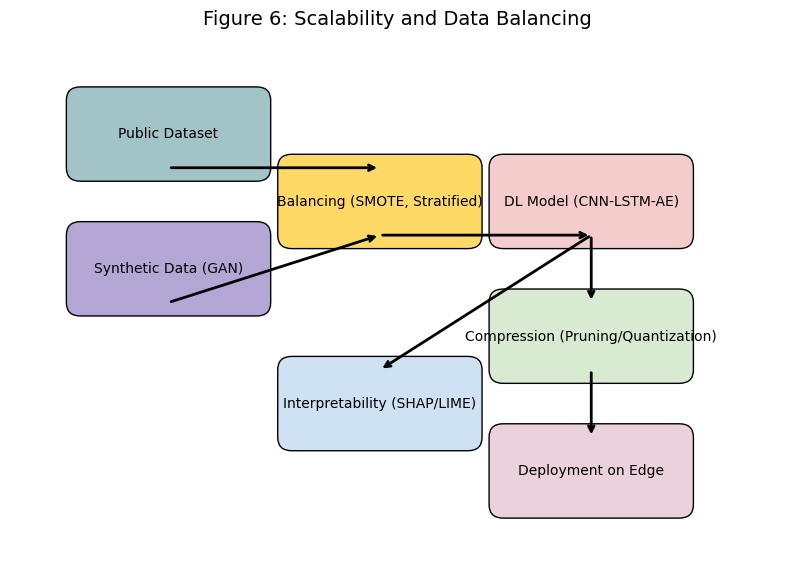

Diagram saved to: /content/drive/MyDrive/Colab Notebooks/tools & technique/graphs_results/scalability_data_balancing_diagram.png


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

fig, ax = plt.subplots(figsize=(10, 7))

# Define box positions
boxes = {
    'Public Dataset': (0.1, 0.8),
    'Synthetic Data (GAN)': (0.1, 0.6),
    'Balancing (SMOTE, Stratified)': (0.4, 0.7),
    'DL Model (CNN-LSTM-AE)': (0.7, 0.7),
    'Compression (Pruning/Quantization)': (0.7, 0.5),
    'Deployment on Edge': (0.7, 0.3),
    'Interpretability (SHAP/LIME)': (0.4, 0.4)
}

# Define unique colors for each box
box_colors = {
    'Public Dataset': '#A2C4C9',
    'Synthetic Data (GAN)': '#B4A7D6',
    'Balancing (SMOTE, Stratified)': '#FFD966',
    'DL Model (CNN-LSTM-AE)': '#F4CCCC',
    'Compression (Pruning/Quantization)': '#D9EAD3',
    'Deployment on Edge': '#EAD1DC',
    'Interpretability (SHAP/LIME)': '#CFE2F3'
}

# Create and label each box
for label, (x, y) in boxes.items():
    ax.add_patch(patches.FancyBboxPatch(
        (x, y), 0.25, 0.1, boxstyle="round,pad=0.02",
        edgecolor='black', facecolor=box_colors[label]))
    ax.text(x + 0.125, y + 0.05, label, ha='center', va='center', fontsize=10)

# Draw arrows
arrows = [
    ('Public Dataset', 'Balancing (SMOTE, Stratified)'),
    ('Synthetic Data (GAN)', 'Balancing (SMOTE, Stratified)'),
    ('Balancing (SMOTE, Stratified)', 'DL Model (CNN-LSTM-AE)'),
    ('DL Model (CNN-LSTM-AE)', 'Compression (Pruning/Quantization)'),
    ('Compression (Pruning/Quantization)', 'Deployment on Edge'),
    ('DL Model (CNN-LSTM-AE)', 'Interpretability (SHAP/LIME)')
]

for src, tgt in arrows:
    x1, y1 = boxes[src]
    x2, y2 = boxes[tgt]
    ax.annotate("",
                xy=(x2 + 0.125, y2 + 0.1 if y2 < y1 else y2),
                xytext=(x1 + 0.125, y1),
                arrowprops=dict(arrowstyle="->", lw=2))

# Formatting
ax.set_xlim(0, 1.1)
ax.set_ylim(0.2, 1.0)
ax.axis('off')
plt.title("Figure 6: Scalability and Data Balancing", fontsize=14)

# Save image
import os
output_path = "/content/drive/MyDrive/Colab Notebooks/tools & technique/graphs_results"
os.makedirs(output_path, exist_ok=True)
output_file = os.path.join(output_path, "scalability_data_balancing_diagram.png")
plt.savefig(output_file, dpi=300, bbox_inches='tight')
plt.show()

print(f"Diagram saved to: {output_file}")


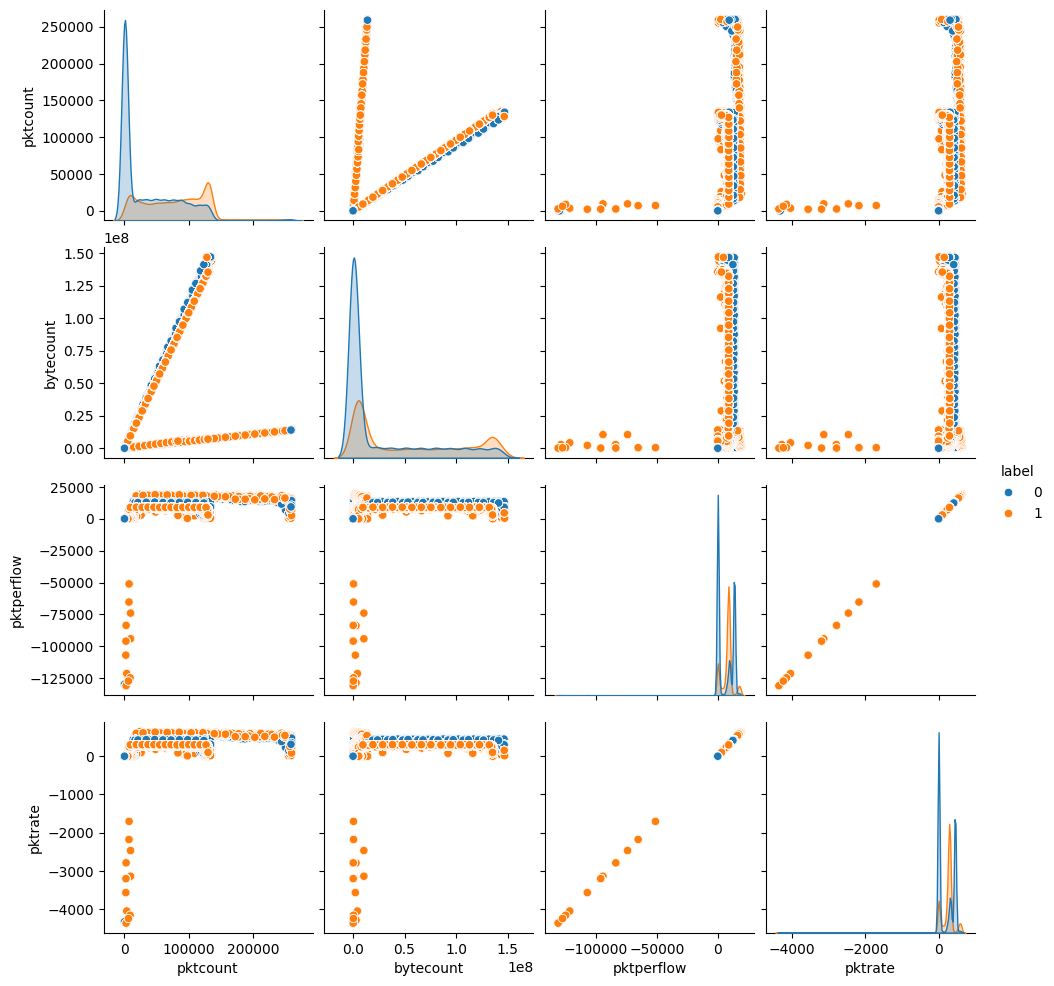

In [ ]:
sns.pairplot(data[['pktcount', 'bytecount', 'pktperflow', 'pktrate', 'label']], hue='label', diag_kind='kde')
plt.show()


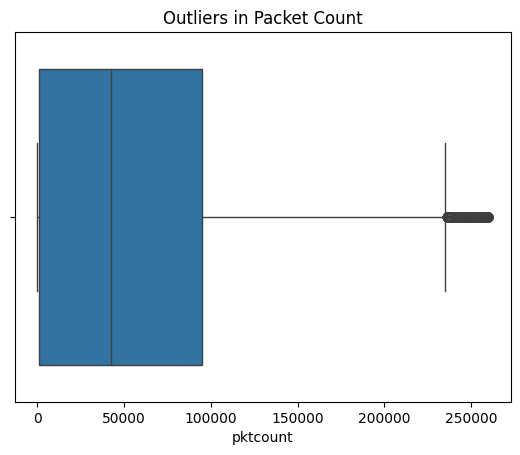

In [ ]:
sns.boxplot(x=data['pktcount'])
plt.title('Outliers in Packet Count')
plt.show()

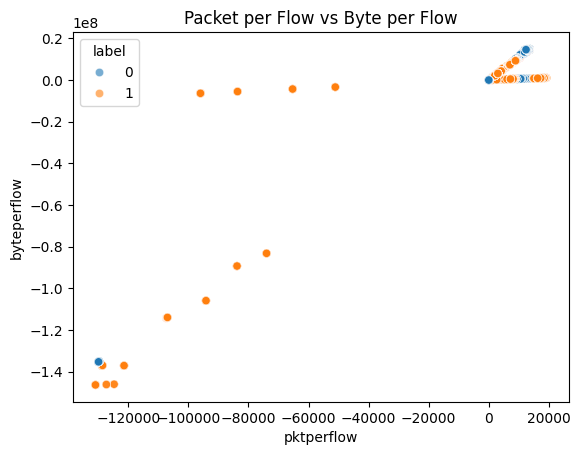

In [ ]:
sns.scatterplot(data=data, x='pktperflow', y='byteperflow', hue='label', alpha=0.6)
plt.title('Packet per Flow vs Byte per Flow')
plt.show()


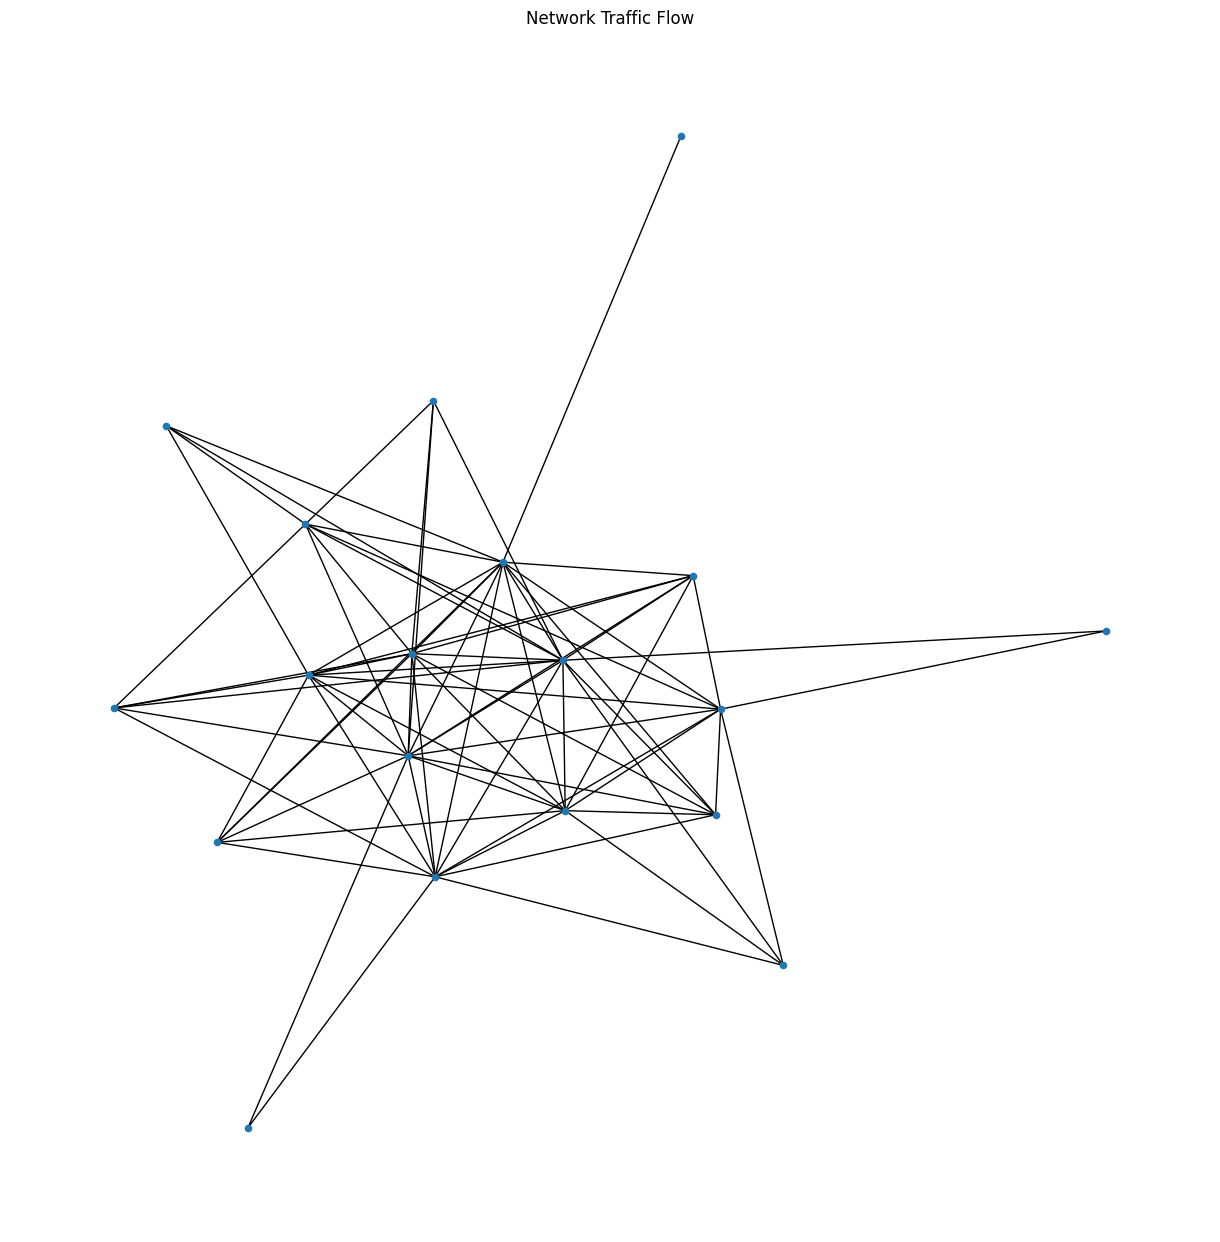

In [ ]:
import networkx as nx

G = nx.from_pandas_edgelist(data, source='src', target='dst', edge_attr=True)
plt.figure(figsize=(12, 12))
nx.draw(G, with_labels=False, node_size=20)
plt.title('Network Traffic Flow')
plt.show()

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.naive_bayes import GaussianNB
import tensorflow as tf
import os
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from io import StringIO

# Define output directory and create it if it doesn’t exist
output_path = "/content/drive/MyDrive/Colab Notebooks/tools & technique/graphs_results"
os.makedirs(output_path, exist_ok=True)

# Load and preprocess the dataset
file_path = '/content/drive/MyDrive/Colab Notebooks/tools & technique/dataset/dataset_sdn.csv'
data = pd.read_csv(file_path)

# Handle missing values if any
data.fillna(0, inplace=True)

# Encode categorical variables (if any)
label_encoder = LabelEncoder()
data['Protocol'] = label_encoder.fit_transform(data['Protocol'])

# Features and target selection
X = data.drop(['label', 'src', 'dst'], axis=1)
y = data['label']

# Normalize the feature set
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Function to save classification report as image
def save_classification_report(y_test, y_pred, model_name):
    report = classification_report(y_test, y_pred)

    # Convert classification report to image
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.text(0.1, 0.5, report, fontsize=12, va='center', ha='left')
    ax.axis('off')  # Hide axes
    plt.title(f'Classification Report - {model_name}')

    # Save the image
    plt.savefig(f"{output_path}/classification_report_{model_name}.png", bbox_inches='tight')
    plt.close()

# 1. Machine Learning Models

# Naive Bayes
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)
y_pred_nb = nb_model.predict(X_test)
print("Naive Bayes:", accuracy_score(y_test, y_pred_nb))

# Save classification report as image
save_classification_report(y_test, y_pred_nb, 'Naive_Bayes')

# Logistic Regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize the logistic regression model with increased max_iter
log_reg = LogisticRegression(random_state=42, max_iter=1000)
log_reg.fit(X_train_scaled, y_train)
y_pred_log_reg = log_reg.predict(X_test_scaled)
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_log_reg))

# Save classification report as image
save_classification_report(y_test, y_pred_log_reg, 'Logistic_Regression')

# SVM
svm_model = SVC()
svm_model.fit(X_train, y_train)
svm_preds = svm_model.predict(X_test)
print("SVM Accuracy:", accuracy_score(y_test, svm_preds))

# Save classification report as image
save_classification_report(y_test, svm_preds, 'SVM')

# KNN
knn_model = KNeighborsClassifier()
knn_model.fit(X_train, y_train)
knn_preds = knn_model.predict(X_test)
print("KNN Accuracy:", accuracy_score(y_test, knn_preds))

# Save classification report as image
save_classification_report(y_test, knn_preds, 'KNN')

# 4. Statistical Analysis
# Simple threshold-based anomaly detection
threshold = X_train.mean(axis=0) + 3 * X_train.std(axis=0)
anomaly_scores = np.sum((X_test > threshold), axis=1)
stats_preds = (anomaly_scores > np.mean(anomaly_scores)).astype(int)
print("Statistical Model Accuracy:", accuracy_score(y_test, stats_preds))

# Save classification report as image
save_classification_report(y_test, stats_preds, 'Statistical_Model')

print("All results saved successfully.")


Naive Bayes: 0.6649575926014663
Logistic Regression Accuracy: 0.7704729503090709
SVM Accuracy: 0.9702429440797355
KNN Accuracy: 0.9758014279553404
Statistical Model Accuracy: 0.5775552254540227
All results saved successfully.


In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report
import os
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Flatten
from sklearn.model_selection import train_test_split

# Define output directory and create it if it doesn’t exist
output_path = "/content/drive/MyDrive/Colab Notebooks/tools & technique/graphs_results"
os.makedirs(output_path, exist_ok=True)

# Example of your dataset loading and preprocessing here
# X_train, X_test, y_train, y_test = your_data_preprocessing_function()

# CNN Model
cnn_model = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])
cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
cnn_model.fit(X_train[..., np.newaxis], y_train, epochs=10, batch_size=32, validation_split=0.2)
cnn_accuracy = cnn_model.evaluate(X_test[..., np.newaxis], y_test, verbose=0)[1]
print("CNN Accuracy:", cnn_accuracy)

# Save CNN classification report as an image
cnn_preds = (cnn_model.predict(X_test[..., np.newaxis]) > 0.5).astype(int).flatten()
cnn_report = classification_report(y_test, cnn_preds)

# Function to save classification report as an image
def save_classification_report_as_image(report, model_name):
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.text(0.1, 0.5, report, fontsize=12, va='center', ha='left')
    ax.axis('off')  # Hide axes
    plt.title(f'Classification Report - {model_name}')
    plt.savefig(f"{output_path}/classification_report_{model_name}.png", bbox_inches='tight')
    plt.close()

save_classification_report_as_image(cnn_report, "CNN")

# LSTM Model
lstm_model = Sequential([
    LSTM(64, activation='relu', input_shape=(X_train.shape[1], 1)),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
lstm_model.fit(X_train[..., np.newaxis], y_train, epochs=10, batch_size=32, validation_split=0.2)
lstm_accuracy = lstm_model.evaluate(X_test[..., np.newaxis], y_test, verbose=0)[1]
print("LSTM Accuracy:", lstm_accuracy)

# Save LSTM classification report as an image
lstm_preds = (lstm_model.predict(X_test[..., np.newaxis]) > 0.5).astype(int).flatten()
lstm_report = classification_report(y_test, lstm_preds)
save_classification_report_as_image(lstm_report, "LSTM")


print("All results saved successfully.")


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2087/2087 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9274 - loss: 0.1755 - val_accuracy: 0.9795 - val_loss: 0.0550
Epoch 2/10
2087/2087 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9771 - loss: 0.0617 - val_accuracy: 0.9851 - val_loss: 0.0390
Epoch 3/10
2087/2087 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9842 - loss: 0.0460 - val_accuracy: 0.9848 - val_loss: 0.0396
Epoch 4/10
2087/2087 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9870 - loss: 0.0326 - val_accuracy: 0.9871 - val_loss: 0.0331
Epoch 5/10
2087/2087 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9899 - loss: 0.0280 - val_accuracy: 0.9930 - val_loss: 0.0191
Epoch 6/10
2087/2087 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9909 - loss: 0.0239 - val_accuracy: 0.9912 - val_loss: 0.0220
Epoch 7/10
2087/2087 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9913 - loss: 0.0233 - val_accuracy: 0.9940 - val_loss: 0.0169
Epoch 8/10
2087/2087 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9926 - loss: 0.0206 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2087/2087 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - accuracy: 0.7378 - loss: 0.5117 - val_accuracy: 0.8997 - val_loss: 0.2409
Epoch 2/10
2087/2087 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step - accuracy: 0.9150 - loss: 0.1993 - val_accuracy: 0.9368 - val_loss: 0.1503
Epoch 3/10
2087/2087 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.9376 - loss: 0.1522 - val_accuracy: 0.9474 - val_loss: 0.1308
Epoch 4/10
2087/2087 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - accuracy: 0.9475 - loss: 0.1259 - val_accuracy: 0.9515 - val_loss: 0.1220
Epoch 5/10
2087/2087 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - accuracy: 0.9563 - loss: 0.1049 - val_accuracy: 0.9712 - val_loss: 0.0752
Epoch 6/10
2087/2087 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - accuracy: 0.9656 - loss: 0.0858 - val_accuracy: 0.9759 - val_loss: 0.0627
Epoch 7/10
2087/2087 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.9732 - loss: 0.0685 - val_accuracy: 0.9822 - val_loss: 0.0508
Epoch 8/10
2087/2087 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.9785 - loss: 0.0564 - val

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
import os
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense

# Define output directory and create it if it doesn’t exist
output_path = "/content/drive/MyDrive/Colab Notebooks/tools & technique/graphs_results"
os.makedirs(output_path, exist_ok=True)

# Example of your dataset loading and preprocessing here
# X_train, X_test, y_train, y_test = your_data_preprocessing_function()

# Autoencoder for Anomaly Detection
input_dim = X_train.shape[1]

# Define the layers of the Autoencoder
input_layer = Input(shape=(input_dim,))
encoded = Dense(64, activation='relu')(input_layer)
encoded = Dense(32, activation='relu')(encoded)

decoded = Dense(64, activation='relu')(encoded)
decoded = Dense(input_dim, activation='sigmoid')(decoded)

# Create the Autoencoder model
autoencoder = Model(inputs=input_layer, outputs=decoded)

# Compile the model
autoencoder.compile(optimizer='adam', loss='mse')

# Train the Autoencoder
autoencoder.fit(X_train, X_train, epochs=10, batch_size=32, validation_split=0.2, verbose=1)

# Use the Autoencoder for Anomaly Detection
X_test_reconstructed = autoencoder.predict(X_test)

# Calculate reconstruction error
reconstruction_error = np.mean(np.square(X_test - X_test_reconstructed), axis=1)

# Define a threshold for anomaly detection
threshold = np.mean(reconstruction_error) + 3 * np.std(reconstruction_error)

# Make predictions: 1 for anomaly, 0 for normal
autoencoder_preds = (reconstruction_error > threshold).astype(int)

# Evaluate the performance
print("Autoencoder Accuracy:", accuracy_score(y_test, autoencoder_preds))
print("Classification Report for Autoencoder:")

# Generate the classification report
autoencoder_report = classification_report(y_test, autoencoder_preds)

# Function to save classification report as image
def save_classification_report_as_image(report, model_name):
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.text(0.1, 0.5, report, fontsize=12, va='center', ha='left')
    ax.axis('off')  # Hide axes
    plt.title(f'Classification Report - {model_name}')
    plt.savefig(f"{output_path}/classification_report_{model_name}.png", bbox_inches='tight')
    plt.close()

# Save Autoencoder classification report as image
save_classification_report_as_image(autoencoder_report, "Autoencoder")

print("Autoencoder classification report saved successfully.")


Epoch 1/10
2087/2087 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 0.6657 - val_loss: 0.5421
Epoch 2/10
2087/2087 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.5477 - val_loss: 0.5401
Epoch 3/10
2087/2087 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.5397 - val_loss: 0.5408
Epoch 4/10
2087/2087 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.5483 - val_loss: 0.5392
Epoch 5/10
2087/2087 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 0.5452 - val_loss: 0.5394
Epoch 6/10
2087/2087 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.5349 - val_loss: 0.5395
Epoch 7/10
2087/2087 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 0.5498 - val_loss: 0.5387
Epoch 8/10
2087/2087 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 0.5341 - val_loss: 0.5383
Epoch 9/10
2087/2087 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.5467 - val_loss: 0.5384
Epoch 10/10
2087/2087 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 0.5407 - val_loss: 0.5384
653/653 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Autoencoder Accuracy: 0.6111457185298769
Classification Report for Autoencoder

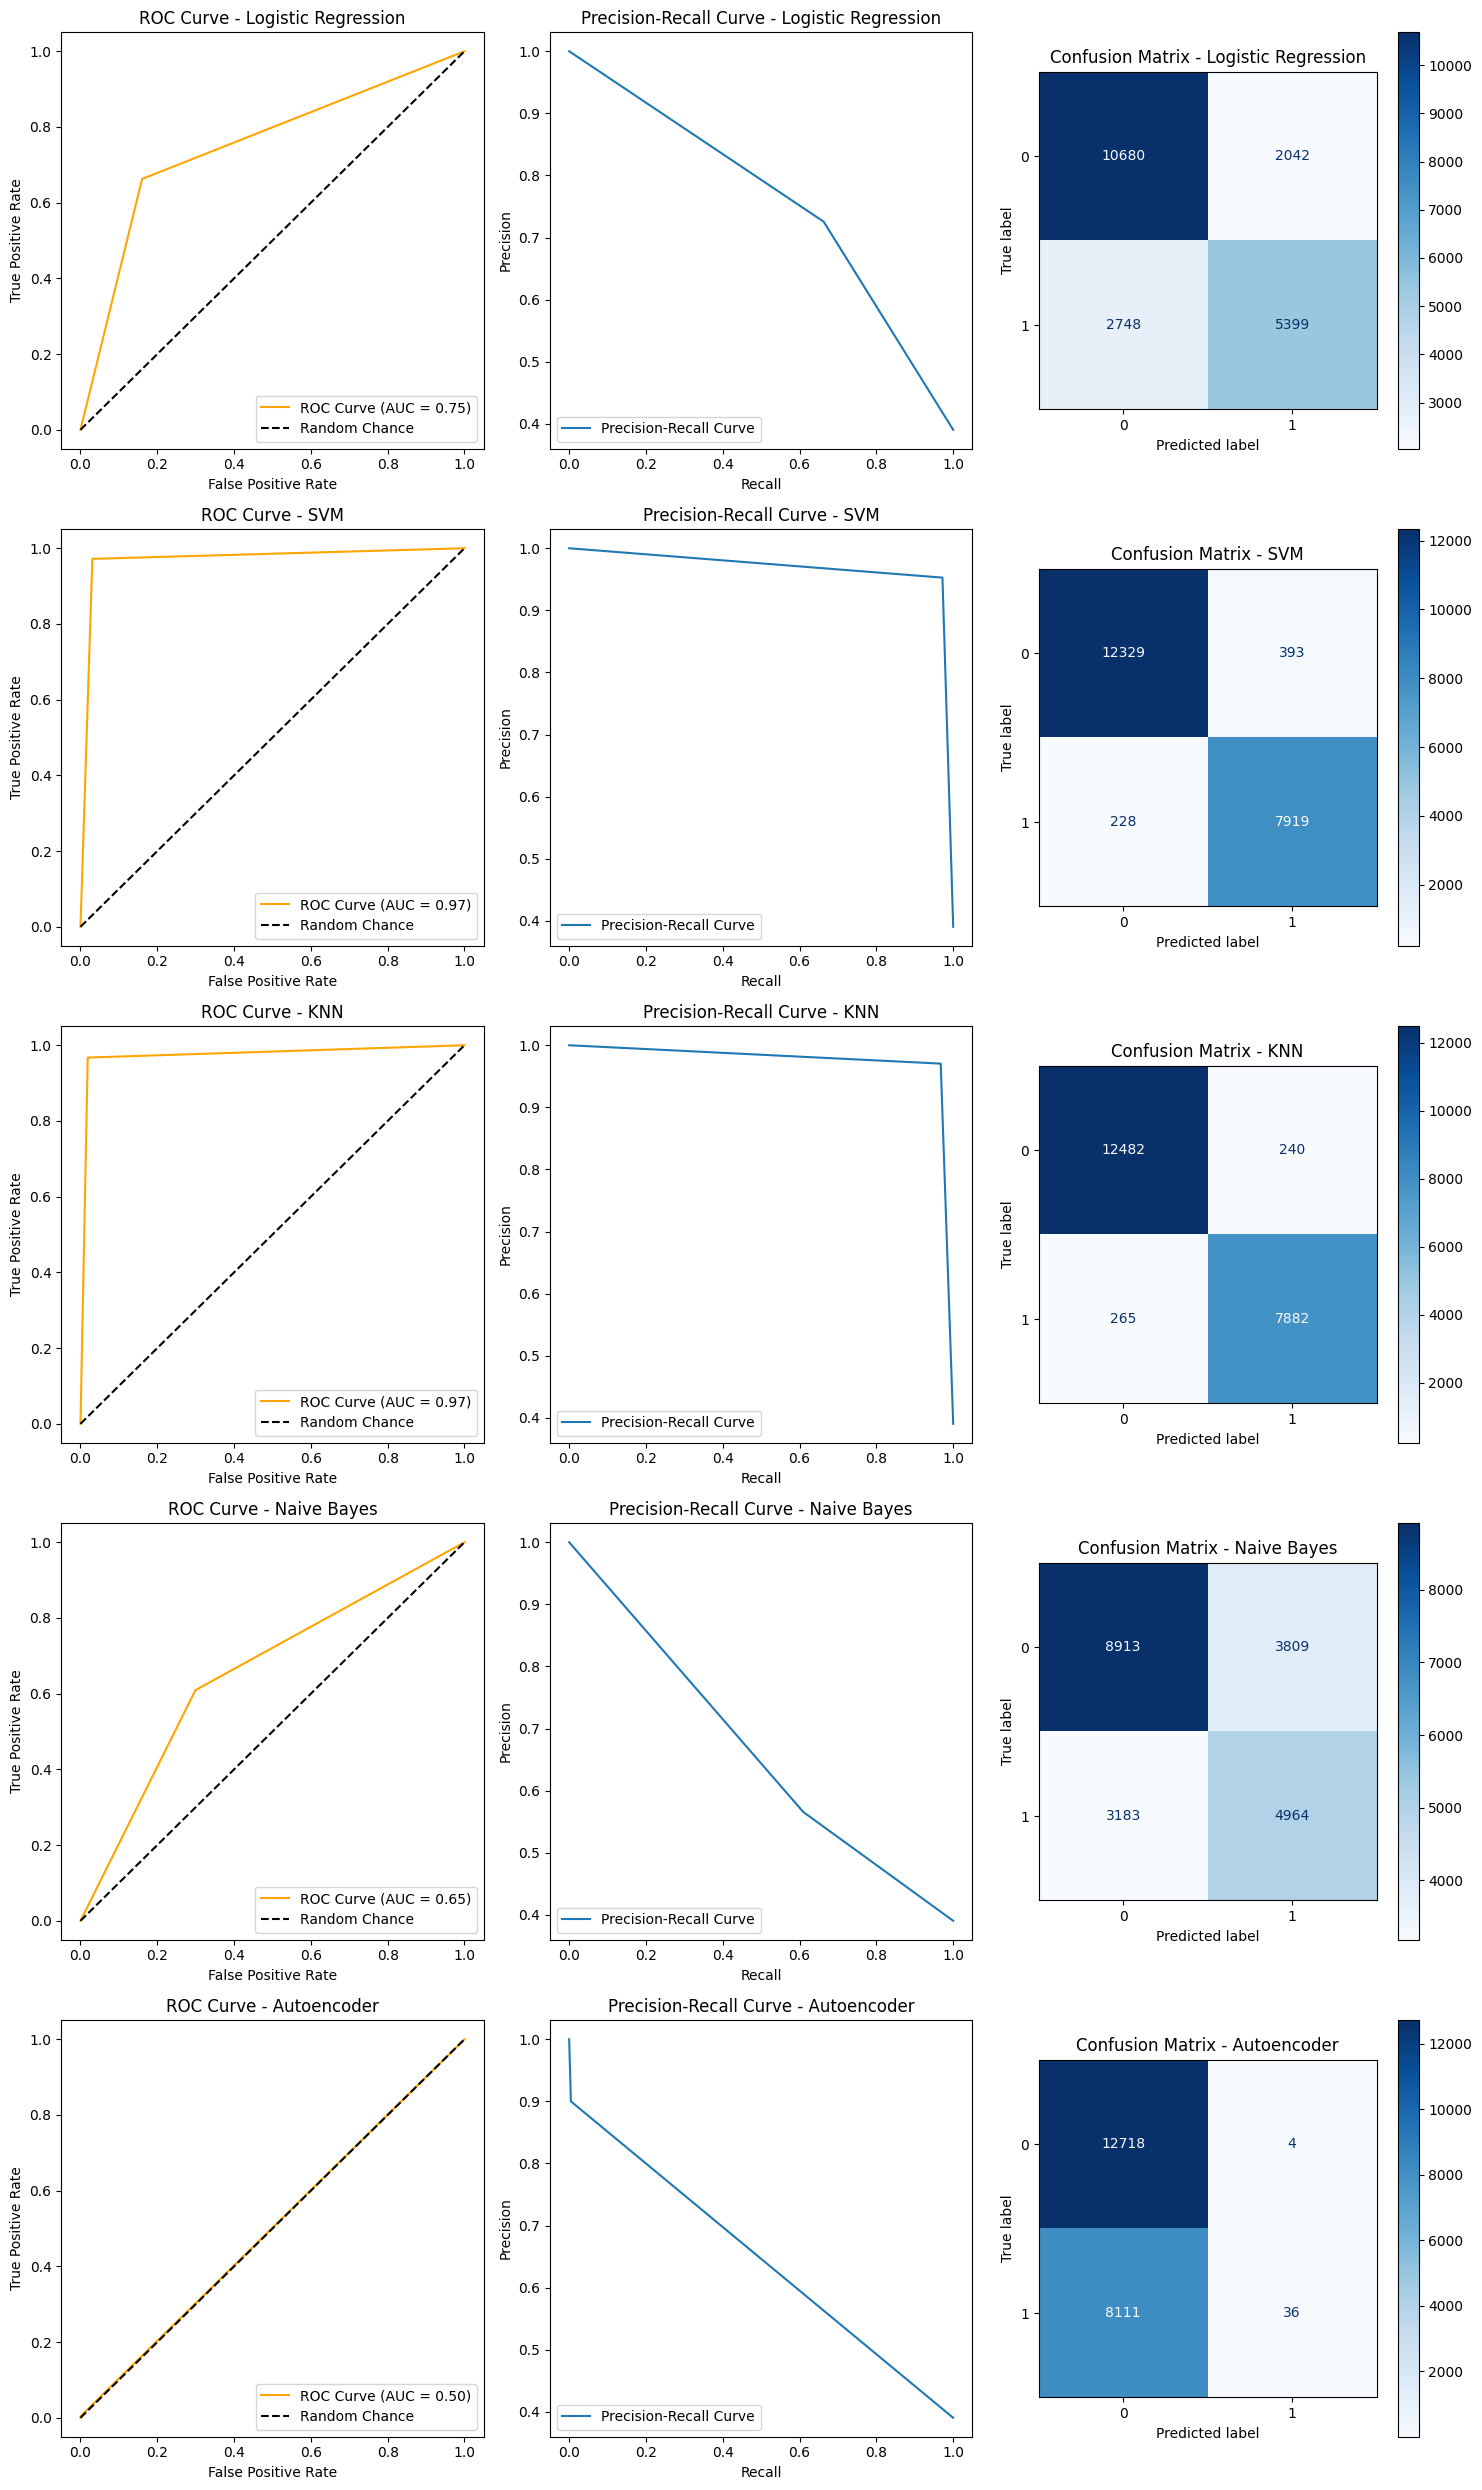

All plots saved successfully as /content/drive/MyDrive/Colab Notebooks/tools & technique/graphs_results/metrics_plots.png


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix, ConfusionMatrixDisplay

# Function to plot the ROC curve
def plot_roc_curve(y_test, y_preds, model_name, ax):
    fpr, tpr, _ = roc_curve(y_test, y_preds)
    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, color='orange', label=f'ROC Curve (AUC = {roc_auc:.2f})')  # Set the color of the ROC curve
    ax.plot([0, 1], [0, 1], 'k--', label='Random Chance')  # Diagonal line for random chance
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'ROC Curve - {model_name}')
    ax.legend(loc='lower right')

# Function to plot the Precision-Recall curve
def plot_precision_recall_curve(y_test, y_preds, model_name, ax):
    precision, recall, _ = precision_recall_curve(y_test, y_preds)
    ax.plot(recall, precision, label=f'Precision-Recall Curve')
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_title(f'Precision-Recall Curve - {model_name}')
    ax.legend(loc='lower left')

# Function to plot the Confusion Matrix with blue color map
def plot_confusion_matrix(y_test, y_preds, model_name, ax):
    cm = confusion_matrix(y_test, y_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues', ax=ax)  # Set the color map to 'Blues'
    ax.set_title(f'Confusion Matrix - {model_name}')

# Apply visualization functions to machine learning models
ml_models = {
    "Logistic Regression": y_pred_log_reg,
    "SVM": svm_preds,
    "KNN": knn_preds,
    "Naive Bayes": y_pred_nb,
    "Autoencoder": autoencoder_preds,
}

# Set up a figure with subplots (1 row per model, 3 columns for ROC, Precision-Recall, and Confusion Matrix)
fig, axes = plt.subplots(len(ml_models), 3, figsize=(15, len(ml_models)*5))

# Loop through each model and plot its metrics
for i, (model_name, y_preds) in enumerate(ml_models.items()):
    plot_roc_curve(y_test, y_preds, model_name, axes[i, 0])  # Plot ROC curve in first column
    plot_precision_recall_curve(y_test, y_preds, model_name, axes[i, 1])  # Plot Precision-Recall curve in second column
    plot_confusion_matrix(y_test, y_preds, model_name, axes[i, 2])  # Plot Confusion Matrix in third column

# Adjust layout to prevent overlapping labels
plt.tight_layout()

# Save the entire figure as an image (e.g., PNG)
output_image_path = "/content/drive/MyDrive/Colab Notebooks/tools & technique/graphs_results/metrics_plots.png"
plt.savefig(output_image_path)

# Show the plots
plt.show()

print(f"All plots saved successfully as {output_image_path}")


653/653 ━━━━━━━━━━━━━━━━━━━━ 1s 859us/step
653/653 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


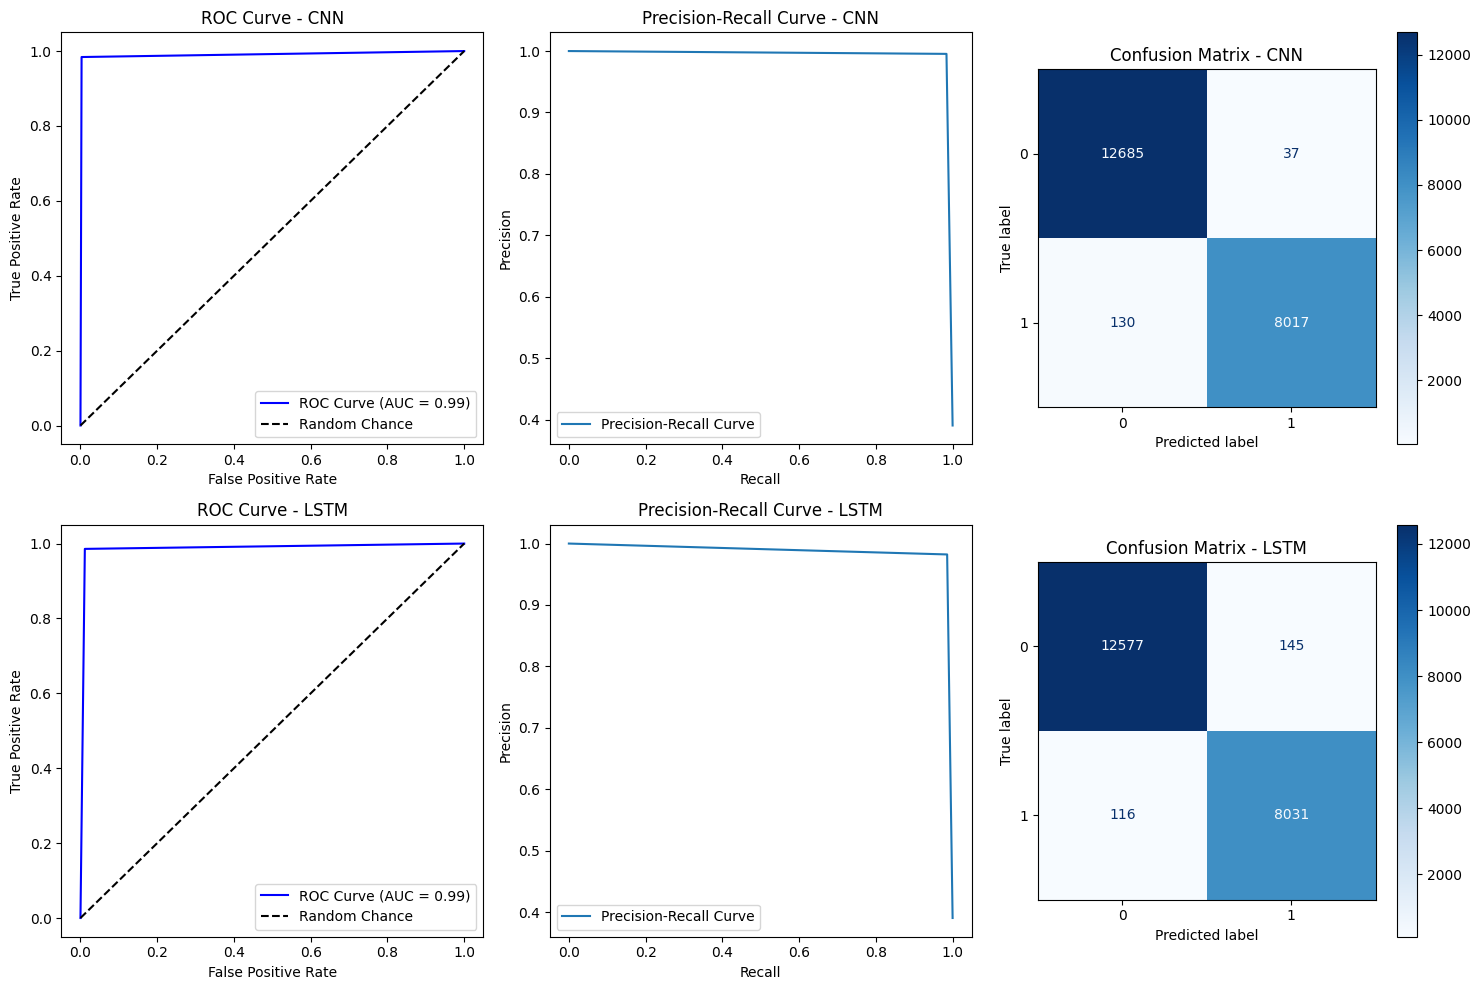

All plots saved successfully as /content/drive/MyDrive/Colab Notebooks/tools & technique/graphs_results/dl_metrics_plots.png


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Function to plot the ROC curve
def plot_roc_curve(y_test, y_preds, model_name, ax):
    fpr, tpr, _ = roc_curve(y_test, y_preds)
    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
    ax.plot([0, 1], [0, 1], 'k--', label='Random Chance')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'ROC Curve - {model_name}')
    ax.legend(loc='lower right')

# Function to plot the Precision-Recall curve
def plot_precision_recall_curve(y_test, y_preds, model_name, ax):
    precision, recall, _ = precision_recall_curve(y_test, y_preds)
    ax.plot(recall, precision, label=f'Precision-Recall Curve')
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_title(f'Precision-Recall Curve - {model_name}')
    ax.legend(loc='lower left')

# Function to plot the Confusion Matrix with blue color map
def plot_confusion_matrix(y_test, y_preds, model_name, ax):
    cm = confusion_matrix(y_test, y_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues', ax=ax)  # Set the color map to 'Blues'
    ax.set_title(f'Confusion Matrix - {model_name}')

# Deep Learning Models (adjust predictions for sigmoid activation)
dl_models = {
    "CNN": (cnn_model.predict(X_test[..., np.newaxis]) > 0.5).astype(int).flatten(),
    "LSTM": (lstm_model.predict(X_test[..., np.newaxis]) > 0.5).astype(int).flatten(),
   # "CNN-LSTM": (cnn_lstm_model.predict(X_test[..., np.newaxis]) > 0.5).astype(int).flatten(),
}

# Set up a figure with subplots (1 row per model, 3 columns for ROC, Precision-Recall, and Confusion Matrix)
fig, axes = plt.subplots(len(dl_models), 3, figsize=(15, len(dl_models) * 5))

# Loop through each deep learning model and plot its metrics
for i, (model_name, y_preds) in enumerate(dl_models.items()):
    plot_roc_curve(y_test, y_preds, model_name, axes[i, 0])  # Plot ROC curve in first column
    plot_precision_recall_curve(y_test, y_preds, model_name, axes[i, 1])  # Plot Precision-Recall curve in second column
    plot_confusion_matrix(y_test, y_preds, model_name, axes[i, 2])  # Plot Confusion Matrix in third column

# Adjust layout to prevent overlapping labels
plt.tight_layout()

# Save the entire figure as an image (e.g., PNG)
output_image_path = "/content/drive/MyDrive/Colab Notebooks/tools & technique/graphs_results/dl_metrics_plots.png"
plt.savefig(output_image_path)

# Show the plots
plt.show()

print(f"All plots saved successfully as {output_image_path}")


In [ ]:
import matplotlib.pyplot as plt

# Function to plot training and validation accuracy
def plot_accuracy(history, model_name):
    plt.figure()
    if 'accuracy' in history.history:
        plt.plot(history.history['accuracy'], label='Training Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    else:  # For older TensorFlow/Keras versions, 'acc' might be used instead of 'accuracy'
        plt.plot(history.history['acc'], label='Training Accuracy')
        plt.plot(history.history['val_acc'], label='Validation Accuracy')
    plt.title(f'Training and Validation Accuracy - {model_name}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Save the plot as an image
    plt.savefig(f"/content/drive/MyDrive/Colab Notebooks/tools & technique/graphs_results/{model_name}_accuracy.png")
    plt.close()  # Close the figure to free up memory

# Function to plot training and validation loss
def plot_loss(history, model_name):
    plt.figure()
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Training and Validation Loss - {model_name}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Save the plot as an image
    plt.savefig(f"/content/drive/MyDrive/Colab Notebooks/tools & technique/graphs_results/{model_name}_loss.png")
    plt.close()  # Close the figure to free up memory

# Train models and save history
cnn_history = cnn_model.fit(X_train[..., np.newaxis], y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=1)
lstm_history = lstm_model.fit(X_train[..., np.newaxis], y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=1)
#cnn_lstm_history = cnn_lstm_model.fit(X_train[..., np.newaxis], y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=1)

# Visualize and save Training and Validation Accuracy/Loss for each model
print("Visualizing and Saving Training and Validation Accuracy/Loss for CNN:")
plot_accuracy(cnn_history, "CNN")
plot_loss(cnn_history, "CNN")

print("Visualizing and Saving Training and Validation Accuracy/Loss for LSTM:")
plot_accuracy(lstm_history, "LSTM")
plot_loss(lstm_history, "LSTM")

#print("Visualizing and Saving Training and Validation Accuracy/Loss for CNN-LSTM:")
#plot_accuracy(cnn_lstm_history, "CNN-LSTM")
#plot_loss(cnn_lstm_history, "CNN-LSTM")

print("All plots saved successfully.")


Epoch 1/10
2087/2087 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9940 - loss: 0.0169 - val_accuracy: 0.9953 - val_loss: 0.0136
Epoch 2/10
2087/2087 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9940 - loss: 0.0148 - val_accuracy: 0.9939 - val_loss: 0.0203
Epoch 3/10
2087/2087 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9946 - loss: 0.0144 - val_accuracy: 0.9920 - val_loss: 0.0179
Epoch 4/10
2087/2087 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9958 - loss: 0.0133 - val_accuracy: 0.9955 - val_loss: 0.0130
Epoch 5/10
2087/2087 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9964 - loss: 0.0101 - val_accuracy: 0.9839 - val_loss: 0.0544
Epoch 6/10
2087/2087 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9955 - loss: 0.0130 - val_accuracy: 0.9942 - val_loss: 0.0171
Epoch 7/10
2087/2087 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9960 - loss: 0.0124 - val_accuracy: 0.9952 - val_loss: 0.0130
Epoch 8/10
2087/2087 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9963 - loss: 0.0093 -

Visualizing and Saving Machine Learning Model Accuracies:
Saved plot as /content/drive/MyDrive/Colab Notebooks/tools & technique/graphs_results/ml_model_accuracies.png


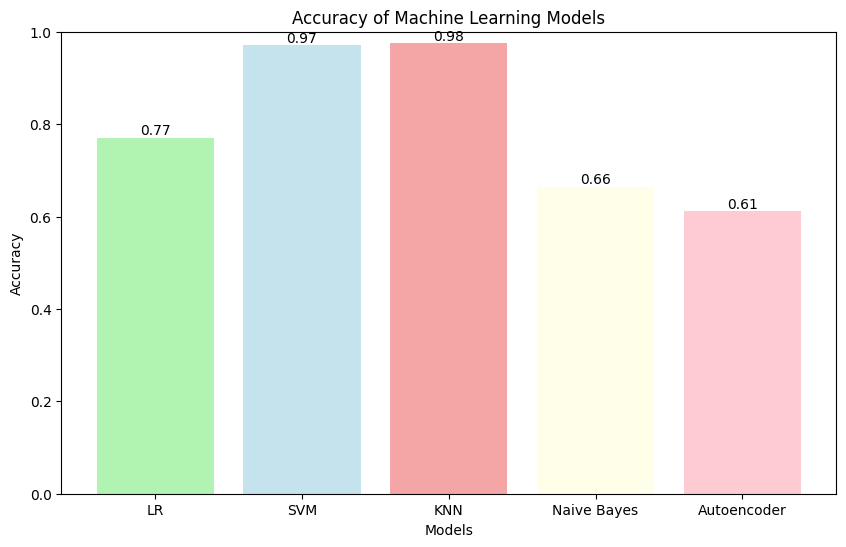

Visualizing and Saving Deep Learning Model Accuracies:
Saved plot as /content/drive/MyDrive/Colab Notebooks/tools & technique/graphs_results/dl_model_accuracies.png


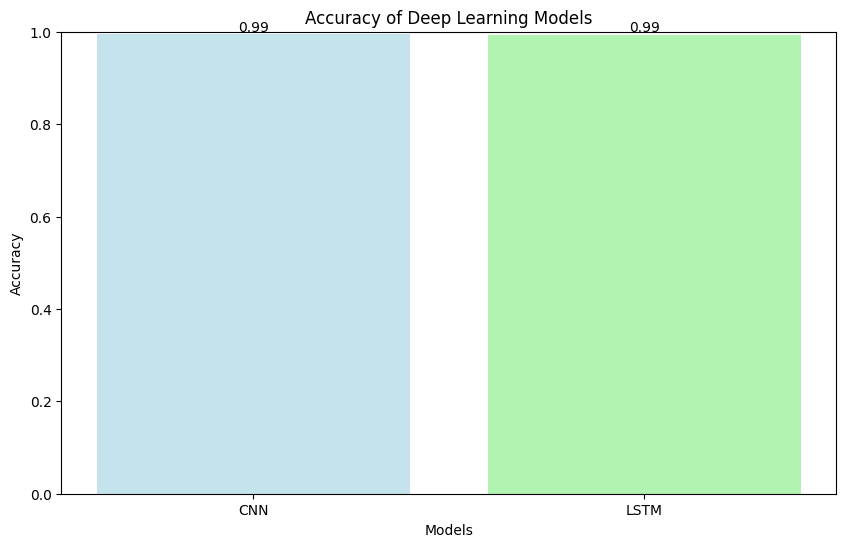

All accuracy plots saved successfully.


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# Function to plot accuracies of all models and save as image
def plot_model_accuracies(model_accuracies, title, colors=None, save_path=None):
    plt.figure(figsize=(10, 6))

    # If colors are provided, use them; otherwise, default to blue
    bar_colors = colors if colors else ['blue'] * len(model_accuracies)

    bars = plt.bar(model_accuracies.keys(), model_accuracies.values(), color=bar_colors, alpha=0.7)
    plt.title(title)
    plt.xlabel('Models')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)  # Accuracy ranges from 0 to 1

    # Annotate each bar with its value
    for bar, accuracy in zip(bars, model_accuracies.values()):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{accuracy:.2f}',
                 ha='center', va='bottom')

    if save_path:
        plt.savefig(save_path)  # Save the plot as an image
        print(f"Saved plot as {save_path}")

    plt.show()

# Calculate Machine Learning Model Accuracies
ml_model_accuracies = {
    "LR": accuracy_score(y_test, y_pred_log_reg),
    "SVM": accuracy_score(y_test, svm_preds),
    "KNN": accuracy_score(y_test, knn_preds),
    "Naive Bayes": accuracy_score(y_test, y_pred_nb),
    "Autoencoder": accuracy_score(y_test, autoencoder_preds),
}

# Plot ML Model Accuracies with custom color (example: light green for ML models)
ml_colors = ['lightgreen', 'lightblue', 'lightcoral', 'lightyellow', 'lightpink']
ml_save_path = "/content/drive/MyDrive/Colab Notebooks/tools & technique/graphs_results/ml_model_accuracies.png"
print("Visualizing and Saving Machine Learning Model Accuracies:")
plot_model_accuracies(ml_model_accuracies, "Accuracy of Machine Learning Models", colors=ml_colors, save_path=ml_save_path)

# Calculate Deep Learning Model Accuracies
dl_model_accuracies = {
    "CNN": cnn_model.evaluate(X_test[..., np.newaxis], y_test, verbose=0)[1],
    "LSTM": lstm_model.evaluate(X_test[..., np.newaxis], y_test, verbose=0)[1],
    #"CNN-LSTM": cnn_lstm_model.evaluate(X_test[..., np.newaxis], y_test, verbose=0)[1],
}

# Plot DL Model Accuracies with custom color (example: light blue for DL models)
dl_colors = ['lightblue', 'lightgreen', 'lightcyan']
dl_save_path = "/content/drive/MyDrive/Colab Notebooks/tools & technique/graphs_results/dl_model_accuracies.png"
print("Visualizing and Saving Deep Learning Model Accuracies:")
plot_model_accuracies(dl_model_accuracies, "Accuracy of Deep Learning Models", colors=dl_colors, save_path=dl_save_path)

print("All accuracy plots saved successfully.")


<ipython-input-31-3fc414288088>:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=data, palette="Set2")


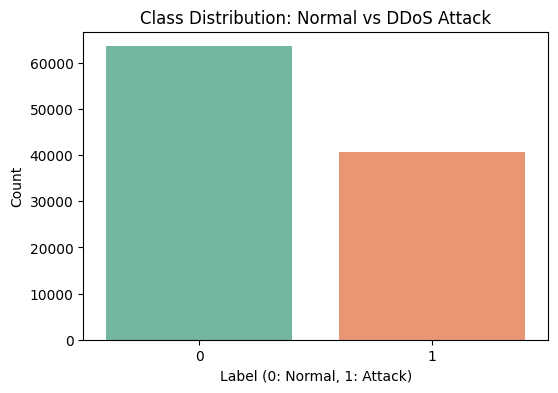

<ipython-input-31-3fc414288088>:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importances, palette='viridis')


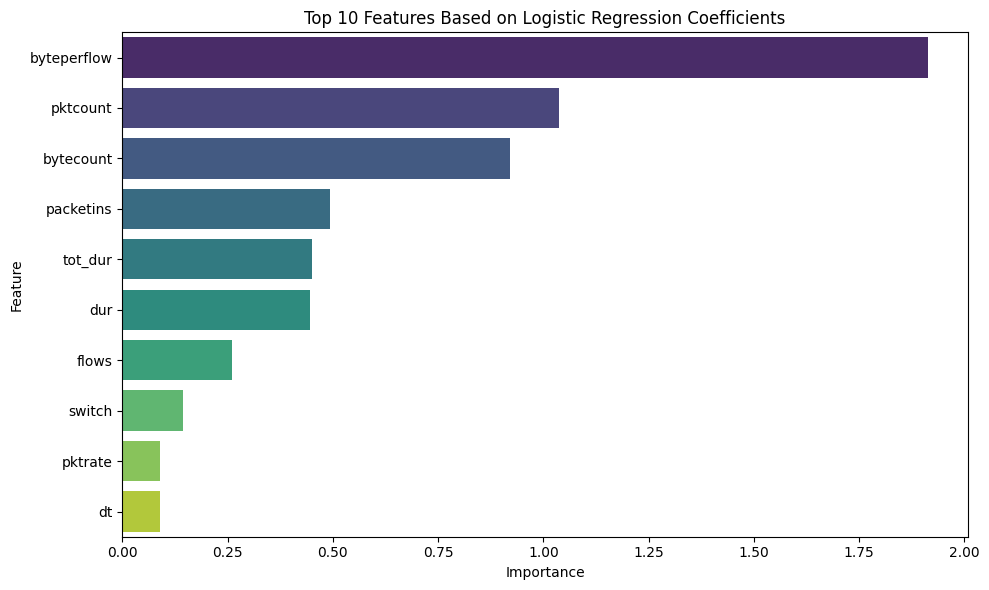

All plots saved successfully.


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import os

# Preprocessing: Ensure the dataset is numeric and clean
X = data.drop(columns=['label', 'src', 'dst', 'Protocol'], errors='ignore')
y = data['label']

# Retain column names after scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)  # Convert back to DataFrame with original column names

# Train a Logistic Regression model for feature importance
log_reg_model = LogisticRegression(random_state=42, max_iter=1000)
log_reg_model.fit(X_scaled, y)

# Get feature importance (absolute value of coefficients)
feature_importances = pd.DataFrame({
    'Feature': X_scaled.columns,
    'Importance': abs(log_reg_model.coef_[0])  # Absolute values of coefficients
}).sort_values(by='Importance', ascending=False).head(10)

# Define the output path to save images
output_path = "/content/drive/MyDrive/Colab Notebooks/tools & technique/graphs_results"
os.makedirs(output_path, exist_ok=True)

# 1. Class Distribution Visualization (Normal vs DDoS)
fig1 = plt.figure(figsize=(6, 4))
sns.countplot(x='label', data=data, palette="Set2")
plt.title('Class Distribution: Normal vs DDoS Attack')
plt.xlabel('Label (0: Normal, 1: Attack)')
plt.ylabel('Count')

# Save the class distribution plot as an image
fig1.savefig(f"{output_path}/class_distribution_normal_vs_ddos.png", bbox_inches='tight')
plt.show()  # Display the plot

# 2. Top 10 Feature Importance Visualization (Using Logistic Regression)
fig2 = plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances, palette='viridis')
plt.title('Top 10 Features Based on Logistic Regression Coefficients')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()

# Save the feature importance plot as an image
fig2.savefig(f"{output_path}/feature_importance_log_reg.png", bbox_inches='tight')
plt.show()  # Display the plot

print("All plots saved successfully.")


In [ ]:
from sklearn.ensemble import IsolationForest

# Fit Isolation Forest for anomaly detection
iso_forest = IsolationForest(contamination=0.1, random_state=42)
data['anomaly'] = iso_forest.fit_predict(X)

# -1 indicates anomaly, 1 indicates normal data
anomalies = data[data['anomaly'] == -1]

print(f'Number of anomalies detected: {len(anomalies)}')


Number of anomalies detected: 10435


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
import os

# Simulate real DDoS feature samples for training GAN
def generate_real_data(n_samples=1000):
    packet_size = np.random.normal(1000, 200, size=(n_samples, 1))  # bytes
    protocol = np.random.randint(0, 3, size=(n_samples, 1))         # 0-2 (TCP, UDP, ICMP)
    tls_version = np.random.randint(0, 2, size=(n_samples, 1))      # 0-1
    tls_cipher = np.random.randint(0, 5, size=(n_samples, 1))       # 0-4
    return np.hstack([packet_size, protocol, tls_version, tls_cipher])

# Build Generator
def build_generator(latent_dim, output_dim):
    model = models.Sequential([
        layers.Dense(64, activation='relu', input_dim=latent_dim),
        layers.Dense(128, activation='relu'),
        layers.Dense(output_dim, activation='linear')
    ])
    return model

# Build Discriminator
def build_discriminator(input_dim):
    model = models.Sequential([
        layers.Dense(128, activation='relu', input_dim=input_dim),
        layers.Dense(64, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# GAN training loop
def train_gan(generator, discriminator, gan_model, latent_dim, n_epochs=1000, batch_size=128):
    half_batch = batch_size // 2
    for epoch in range(n_epochs):
        # Train discriminator
        real_data = generate_real_data(half_batch)
        real_labels = np.ones((half_batch, 1))
        fake_latent = np.random.normal(0, 1, (half_batch, latent_dim))
        fake_data = generator.predict(fake_latent)
        fake_labels = np.zeros((half_batch, 1))

        d_loss_real = discriminator.train_on_batch(real_data, real_labels)
        d_loss_fake = discriminator.train_on_batch(fake_data, fake_labels)

        # Train generator
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        valid_y = np.ones((batch_size, 1))
        gan_loss = gan_model.train_on_batch(noise, valid_y)

        if epoch % 100 == 0:
            print(f"Epoch {epoch}: D Loss={np.mean([d_loss_real[0], d_loss_fake[0]])}, G Loss={gan_loss}")

# Prepare GAN
latent_dim = 10
output_dim = 4
generator = build_generator(latent_dim, output_dim)
discriminator = build_discriminator(output_dim)

# Build GAN model
discriminator.trainable = False
gan_input = tf.keras.Input(shape=(latent_dim,))
gan_output = discriminator(generator(gan_input))
gan_model = tf.keras.Model(gan_input, gan_output)
gan_model.compile(optimizer='adam', loss='binary_crossentropy')

# Train GAN
train_gan(generator, discriminator, gan_model, latent_dim, n_epochs=1000, batch_size=128)

# Generate synthetic data
n_synthetic_samples = 1000
latent_samples = np.random.normal(0, 1, (n_synthetic_samples, latent_dim))
synthetic_data = generator.predict(latent_samples)

# Create DataFrame and save CSV
columns = ["packet_size", "protocol", "tls_version", "tls_cipher"]
df_synthetic = pd.DataFrame(synthetic_data, columns=columns)
df_synthetic["label"] = 1  # DDoS label

# Set output path and save
output_path = "/content/drive/MyDrive/Colab Notebooks/tools & technique/graphs_results"
os.makedirs(output_path, exist_ok=True)
csv_path = os.path.join(output_path, "gan_synthetic_data.csv")
df_synthetic.to_csv(csv_path, index=False)
print(f"Synthetic data saved to: {csv_path}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py:82: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


Epoch 0: D Loss=0.173048734664917, G Loss=0.6891592144966125
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s

In [ ]:
#!pip install lime
import tensorflow as tf
import tensorflow_model_optimization as tfmot
import numpy as np

print("TensorFlow:", tf.__version__)
print("TFMOT:", tfmot.__version__)
print("NumPy:", np.__version__)

TensorFlow: 2.15.0
TFMOT: 0.7.5
NumPy: 1.25.2


In [ ]:
pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=6fd51da79cca862517645e7f02fe6a46a35c2079176cecaf04c7008eb0dda9a9
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [ ]:
!pip install tensorflow==2.15.0 tensorflow-model-optimization==0.7.5

!pip install numpy==1.25.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.3/475.3 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.2/241.2 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 35.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 36.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 35.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 21.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 59.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 21.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 5.9 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.17.2
    Uninstalling wrapt-1.17.2:
      Successfully uninstalled wrapt-1.17.2
  Attempting uninstall: protobuf
    Found existing instal

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 74.1 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
blosc2 3.5.1 requires numpy>=1.26, but you have numpy 1.25.2 which is incompatible.
tensorflow-decision-forests 1.11.0 requires tensorflow==2.18.0, but you have tensorflow 2.15.0 which is incompatible.
ydf 0.12.0 requires protobuf<6.0.0,>=5.29.1, but you have protobuf 4.25.8 which is incompatible.
tf-keras 2.18.0 requires tensorflow<2.19,>=2.18, but you have tensorflow 2.15.0 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.25.2 which is incompatible.
tensorflow-text 2.18.1 requires tensorflow<2.19,>=2.18.0, bu

In [ ]:
#!pip install --upgrade numpy

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TerminateOnNaN
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

# --- Step 1: Load and Merge Data ---
data_original = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/tools & technique/dataset/dataset_sdn.csv')
data_gan = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/tools & technique/dataset/gan_synthetic_data (3).csv')

data_original.columns = data_original.columns.str.lower()
data_gan.columns = data_gan.columns.str.lower()

# Align column names
all_columns = sorted(set(data_original.columns).union(set(data_gan.columns)))
for col in all_columns:
    if col not in data_original.columns:
        data_original[col] = 0
    if col not in data_gan.columns:
        data_gan[col] = 0

data_original = data_original[all_columns]
data_gan = data_gan[all_columns]

# 🔧 Ensure unique columns before concat
data_original = data_original.loc[:, ~data_original.columns.duplicated()]
data_gan = data_gan.loc[:, ~data_gan.columns.duplicated()]

data_combined = pd.concat([data_original, data_gan], ignore_index=True)

# --- Step 2: Feature Engineering ---
tls_features = [col for col in ['tls_version', 'tls_cipher'] if col in data_combined.columns]
numeric_features = [
    'pktcount', 'bytecount', 'dur', 'dur_nsec', 'tot_dur', 'flows',
    'packetins', 'pktperflow', 'byteperflow', 'pktrate',
    'port_no', 'tx_bytes', 'rx_bytes', 'tx_kbps', 'rx_kbps', 'tot_kbps',
    'protocol'
]
feature_cols = [col for col in tls_features + numeric_features if col in data_combined.columns]
X_df = data_combined[feature_cols].copy()

# Fill numeric columns and one-hot encode
X_df = X_df.apply(pd.to_numeric, errors='coerce')
X_df = X_df.fillna(X_df.mean(numeric_only=True))
X_encoded = pd.get_dummies(X_df)

# --- Step 3: Prepare Features and Labels ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_encoded)
X = X_scaled.astype(np.float32)
y = np.clip(data_combined['label'].astype(int).values, 0, 1)

# --- Step 4: Reshape and Split ---
X = X.reshape((X.shape[0], 1, X.shape[1]))
X_train_dl, X_test_dl, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Step 5: Build Improved CNN-LSTM Model ---
def build_improved_cnn_lstm(input_shape):
    inputs = Input(shape=input_shape)
    x = Conv1D(64, 3, activation='relu', padding='same')(inputs)
    x = BatchNormalization()(x)
    x = LSTM(64)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    return Model(inputs, outputs)

model = build_improved_cnn_lstm(X_train_dl.shape[1:])
optimizer = Adam(learning_rate=0.001, clipnorm=1.0)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# --- Step 6: Class Weights ---
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))

# --- Step 7: Train ---
model.fit(
    X_train_dl, y_train,
    validation_split=0.1,
    epochs=10,
    batch_size=64,
    callbacks=[TerminateOnNaN()],
    class_weight=class_weights_dict,
    verbose=1
)

# --- Step 8: Feature Extraction ---
feature_model = Model(inputs=model.input, outputs=model.layers[-2].output)
train_features = feature_model.predict(X_train_dl)
test_features = feature_model.predict(X_test_dl)

# Replace any NaNs (if any)
train_features = np.nan_to_num(train_features)
test_features = np.nan_to_num(test_features)

# --- Step 9: Train SVM ---
svm = SVC(probability=True)
svm.fit(train_features, y_train)

# --- Step 10: Evaluate ---
preds = svm.predict(test_features)
print("✅ Hybrid CNN-LSTM-SVM Ensemble Accuracy:", accuracy_score(y_test, preds))
print("🔍 Classification Report:\n", classification_report(y_test, preds))


Epoch 1/10
1186/1186 ━━━━━━━━━━━━━━━━━━━━ 24s 12ms/step - accuracy: 0.9008 - loss: 0.2220 - val_accuracy: 0.9725 - val_loss: 0.0706
Epoch 2/10
1186/1186 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.9682 - loss: 0.0759 - val_accuracy: 0.9760 - val_loss: 0.0637
Epoch 3/10
1186/1186 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9735 - loss: 0.0645 - val_accuracy: 0.9797 - val_loss: 0.0497
Epoch 4/10
1186/1186 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.9752 - loss: 0.0595 - val_accuracy: 0.9822 - val_loss: 0.0450
Epoch 5/10
1186/1186 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9779 - loss: 0.0542 - val_accuracy: 0.9835 - val_loss: 0.0372
Epoch 6/10
1186/1186 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.9807 - loss: 0.0480 - val_accuracy: 0.9832 - val_loss: 0.0407
Epoch 7/10
1186/1186 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9812 - loss: 0.0455 - val_accuracy: 0.9836 - val_loss: 0.0395
Epoch 8/10
1186/1186 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.9825 - loss: 0.0427 

In [ ]:
"""from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report

# --- Step 1: Initialize Incremental SVM ---
inc_svm = SGDClassifier(loss='hinge')  # 'hinge' = linear SVM

# --- Step 2: Initial Training on Extracted Features ---
inc_svm.partial_fit(train_features, y_train, classes=np.unique(y_train))

# --- Step 3: Evaluate After Initial Training ---
y_pred_initial = inc_svm.predict(test_features)
print("📊 Classification Report after initial training (CNN-LSTM features):")
print(classification_report(y_test, y_pred_initial))

# --- Step 4: Simulate Streaming Batch Update (Optional) ---
# Assuming you later receive new CNN-LSTM extracted features from a new batch:
# new_batch_features, new_batch_labels = ...

# Example placeholder (just reusing part of test set for demonstration):
stream_X = test_features[:100]
stream_y = y_test[:100]

# Online update with new batch
inc_svm.partial_fit(stream_X, stream_y)

# --- Step 5: Evaluate After Streaming Update ---
y_pred_updated = inc_svm.predict(test_features)
print("📊 Classification Report after streaming update:")
print(classification_report(y_test, y_pred_updated))
 """

In [ ]:
"""# --- Load GAN-Augmented Test Set ---
# Replace this with your actual loading method
X_test_after_gan = np.load('/content/drive/MyDrive/Colab Notebooks/data/X_test_after_gan.npy')  # shape: (samples, time_steps, features)
y_test = np.load('/content/drive/MyDrive/Colab Notebooks/data/y_test_after_gan.npy')            # shape: (samples,)
"""

In [ ]:
from tensorflow.keras.models import load_model, Model
import joblib
cnn_lstm_model = load_model("/content/drive/MyDrive/Colab Notebooks/tools & technique/graphs_results/cnn_lstm_model.keras")
svm_ensemble = joblib.load("/content/drive/MyDrive/Colab Notebooks/tools & technique/graphs_results/svm_model.joblib")


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Input, Conv1D, LSTM, Dense
import joblib

# --- Load Datasets ---
data_original = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/tools & technique/dataset/dataset_sdn.csv')
data_gan = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/tools & technique/dataset/gan_synthetic_data (3).csv')

# --- Preprocessing ---
data_original.columns = data_original.columns.str.lower()
data_gan.columns = data_gan.columns.str.lower()
all_columns = sorted(set(data_original.columns).union(set(data_gan.columns)))

data_original.columns = data_original.columns.str.lower()
data_gan.columns = data_gan.columns.str.lower()

# Define all_columns as the union of both dataset columns
all_columns = sorted(set(data_original.columns).union(set(data_gan.columns)))

# After adding missing columns:
for col in all_columns:
    if col not in data_original.columns:
        data_original[col] = 0
    if col not in data_gan.columns:
        data_gan[col] = 0

data_original = data_original[all_columns]
data_gan = data_gan[all_columns]

# Remove duplicates if any after adding columns
data_original = data_original.loc[:, ~data_original.columns.duplicated()]
data_gan = data_gan.loc[:, ~data_gan.columns.duplicated()]

# Reset index to avoid index issues on concat
data_original.reset_index(drop=True, inplace=True)
data_gan.reset_index(drop=True, inplace=True)

print("Duplicates in data_original columns:", data_original.columns[data_original.columns.duplicated()].tolist())
print("Duplicates in data_gan columns:", data_gan.columns[data_gan.columns.duplicated()].tolist())

# Now concatenate safely
data_combined = pd.concat([data_original, data_gan], ignore_index=True)

# --- Feature Columns ---
tls_features = [col for col in ['tls_version', 'tls_cipher'] if col in data_combined.columns]
numeric_features = [
    'pktcount', 'bytecount', 'dur', 'dur_nsec', 'tot_dur', 'flows',
    'packetins', 'pktperflow', 'byteperflow', 'pktrate',
    'port_no', 'tx_bytes', 'rx_bytes', 'tx_kbps', 'rx_kbps', 'tot_kbps',
    'protocol'
]
feature_cols = [col for col in (tls_features + numeric_features) if col in data_combined.columns]

# --- Prepare After-GAN Test Features ---
X_combined = pd.get_dummies(data_combined[feature_cols].fillna(data_combined[feature_cols].mean(numeric_only=True)))
X_combined = X_combined.values.astype(np.float32)
X_combined = X_combined.reshape((X_combined.shape[0], 1, X_combined.shape[1]))
y_combined = np.clip(data_combined['label'].astype(int).values, 0, 1)

# Train-test split
_, X_test_dl, _, y_test = train_test_split(X_combined, y_combined, test_size=0.2, random_state=42)

# --- Load Trained Models (After GAN) ---
cnn_lstm_model = load_model("/content/drive/MyDrive/Colab Notebooks/tools & technique/graphs_results/cnn_lstm_model.keras")
svm_ensemble = joblib.load("/content/drive/MyDrive/Colab Notebooks/tools & technique/graphs_results/svm_model.joblib")

# Extract test features using CNN-LSTM model
feature_extractor = Model(inputs=cnn_lstm_model.input, outputs=cnn_lstm_model.layers[-2].output)
test_features = np.nan_to_num(feature_extractor.predict(X_test_dl), nan=0.0)
svm_probs = svm_ensemble.predict_proba(test_features)[:, 1]

# --- Prepare Before-GAN Test Features ---
X_df_orig = data_original[feature_cols].copy().fillna(data_original[feature_cols].mean(numeric_only=True))
X_encoded_orig = pd.get_dummies(X_df_orig)
X_orig = X_encoded_orig.values.astype(np.float32)
X_orig = X_orig.reshape((X_orig.shape[0], 1, X_orig.shape[1]))
y_orig = np.clip(data_original['label'].astype(int).values, 0, 1)

X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(X_orig, y_orig, test_size=0.2, random_state=42)

# --- Rebuild CNN-LSTM Model for Original Data ---
def build_cnn_lstm(input_shape):
    inputs = Input(shape=input_shape)
    x = Conv1D(64, kernel_size=3, activation='relu', padding='same')(inputs)
    x = LSTM(64)(x)
    x = Dense(16, activation='relu')(x)
    outputs = Dense(1, activation='sigmoid')(x)
    return Model(inputs=inputs, outputs=outputs)

model_orig = build_cnn_lstm(X_train_orig.shape[1:])
model_orig.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model_orig.fit(X_train_orig, y_train_orig, epochs=10, batch_size=64, validation_split=0.1, verbose=0)

# Extract original test features
extractor_orig = Model(inputs=model_orig.input, outputs=model_orig.layers[-2].output)
test_feats_orig = np.nan_to_num(extractor_orig.predict(X_test_orig), nan=0.0)

# Train new SVM on original features
# Use pretrained SVM model for original data features
svm_probs_orig = svm_ensemble.predict_proba(test_feats_orig)[:, 1]


# --- Plot ROC Curves ---
fpr_before, tpr_before, _ = roc_curve(y_test_orig, svm_probs_orig)
roc_auc_before = auc(fpr_before, tpr_before)

fpr_after, tpr_after, _ = roc_curve(y_test, svm_probs)
roc_auc_after = auc(fpr_after, tpr_after)

plt.figure(figsize=(8, 6))
plt.plot(fpr_before, tpr_before, 'r--', label=f'Before GAN (AUC = {roc_auc_before:.2f})')
plt.plot(fpr_after, tpr_after, 'g-', label=f'After GAN (AUC = {roc_auc_after:.2f})')
plt.plot([0, 1], [0, 1], 'k:', label='Random Guess')
plt.title('Figure 5.1: ROC Curves Before and After GAN Augmentation')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/Colab Notebooks/tools & technique/graphs_results/roc_comparison_gan.png')
plt.show()


Duplicates in data_original columns: []
Duplicates in data_gan columns: []


ValueError: in user code:

    File "/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py", line 2440, in predict_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py", line 2425, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py", line 2413, in run_step  **
        outputs = model.predict_step(data)
    File "/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py", line 2381, in predict_step
        return self(x, training=False)
    File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/usr/local/lib/python3.11/dist-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "model_2" is incompatible with the layer: expected shape=(None, 1, 19), found shape=(None, 1, 1021)


In [ ]:
"""import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.optimizers import Adam  # Fresh optimizer
from tensorflow.keras.callbacks import TerminateOnNaN
from sklearn.svm import SVC
import joblib
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# --- Load Trained CNN-LSTM and SVM (After GAN) ---
cnn_lstm_model = load_model("/content/drive/MyDrive/Colab Notebooks/tools & technique/graphs_results/cnn_lstm_model.keras")
svm_ensemble = joblib.load("/content/drive/MyDrive/Colab Notebooks/tools & technique/graphs_results/svm_model.joblib")

# --- Predict with After-GAN Models ---
svm_probs = svm_ensemble.predict_proba(test_features)[:, 1]  # test_features from CNN-LSTM extractor

# --- Prepare BEFORE GAN (original dataset only) ---
X_df_original = data_original[feature_cols].copy().fillna(data_original[feature_cols].mean(numeric_only=True))
X_encoded_original = pd.get_dummies(X_df_original)
X_original = X_encoded_original.values.astype(np.float32)
y_original = np.clip(data_original['label'].astype(int).values, 0, 1)
X_original = X_original.reshape((X_original.shape[0], 1, X_original.shape[1]))

# --- Split original data ---
X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(X_original, y_original, test_size=0.2, random_state=42)

# --- Build and Train CNN-LSTM Model ---
# Assume this function builds a CNN-LSTM and returns (inputs, outputs)
input_shape_orig = X_train_orig.shape[1:]
inputs_orig, outputs_orig = build_cnn_lstm(input_shape_orig)  # Make sure this returns Keras Input and Output
model_orig = Model(inputs=inputs_orig, outputs=outputs_orig)

# Use a fresh optimizer instance (IMPORTANT FIX)
model_orig.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model_orig.fit(X_train_orig, y_train_orig,
               epochs=10,
               batch_size=64,
               validation_split=0.1,
               callbacks=[TerminateOnNaN()])

# --- Feature Extraction ---
extractor_orig = Model(inputs=model_orig.input, outputs=model_orig.layers[-2].output)
train_feats_orig = np.nan_to_num(extractor_orig.predict(X_train_orig), nan=0.0)
test_feats_orig = np.nan_to_num(extractor_orig.predict(X_test_orig), nan=0.0)

# --- Train SVM on extracted features ---
svm_orig = SVC(probability=True)
svm_orig.fit(train_feats_orig, y_train_orig)
svm_probs_orig = svm_orig.predict_proba(test_feats_orig)[:, 1]

# --- ROC Curve Calculation ---
fpr_before, tpr_before, _ = roc_curve(y_test_orig, svm_probs_orig)
roc_auc_before = auc(fpr_before, tpr_before)

fpr_after, tpr_after, _ = roc_curve(y_test, svm_probs)
roc_auc_after = auc(fpr_after, tpr_after)

# --- Plot ROC Comparison ---
plt.figure(figsize=(8, 6))
plt.plot(fpr_before, tpr_before, 'r--', label=f'Before GAN (AUC = {roc_auc_before:.2f})')
plt.plot(fpr_after, tpr_after, 'g-', label=f'After GAN (AUC = {roc_auc_after:.2f})')
plt.plot([0, 1], [0, 1], 'k:', label='Random Guess')
plt.title('Figure 5.1: ROC Curves Before and After GAN Augmentation')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/Colab Notebooks/tools & technique/graphs_results/roc_comparison_gan.png')
plt.show()

"""

'import matplotlib.pyplot as plt\nfrom sklearn.metrics import roc_curve, auc\nfrom tensorflow.keras.models import load_model, Model\nfrom tensorflow.keras.optimizers import Adam  # Fresh optimizer\nfrom tensorflow.keras.callbacks import TerminateOnNaN\nfrom sklearn.svm import SVC\nimport joblib\nimport numpy as np\nimport pandas as pd\nfrom sklearn.model_selection import train_test_split\n\n# --- Load Trained CNN-LSTM and SVM (After GAN) ---\ncnn_lstm_model = load_model("/content/drive/MyDrive/Colab Notebooks/tools & technique/graphs_results/cnn_lstm_model.keras")\nsvm_ensemble = joblib.load("/content/drive/MyDrive/Colab Notebooks/tools & technique/graphs_results/svm_model.joblib")\n\n# --- Predict with After-GAN Models ---\nsvm_probs = svm_ensemble.predict_proba(test_features)[:, 1]  # test_features from CNN-LSTM extractor\n\n# --- Prepare BEFORE GAN (original dataset only) ---\nX_df_original = data_original[feature_cols].copy().fillna(data_original[feature_cols].mean(numeric_only=Tru

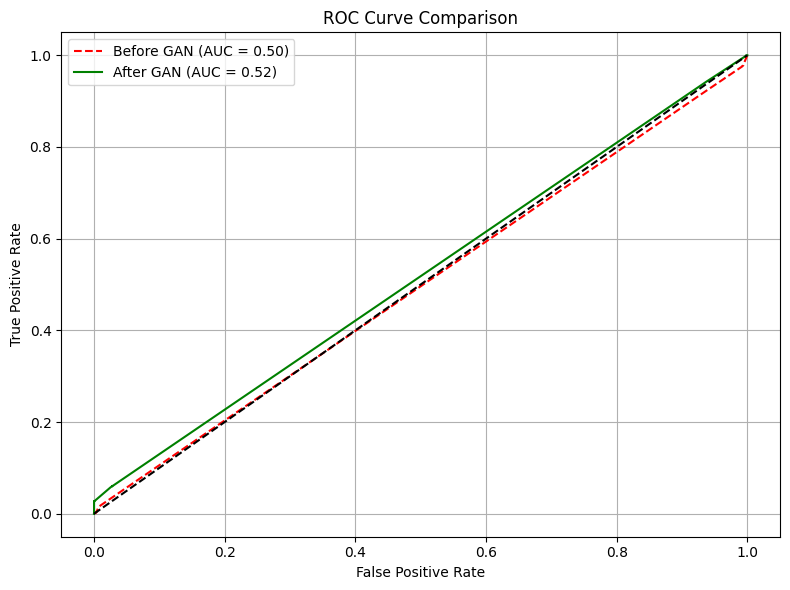

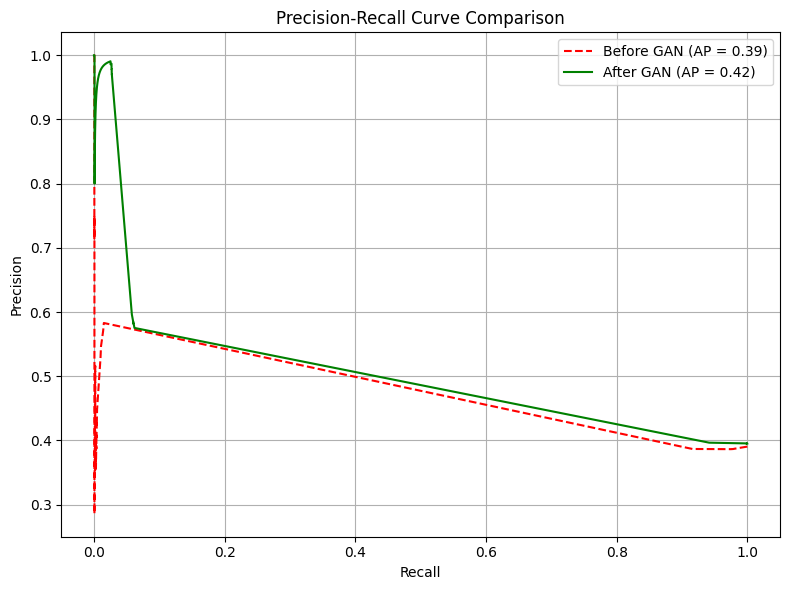

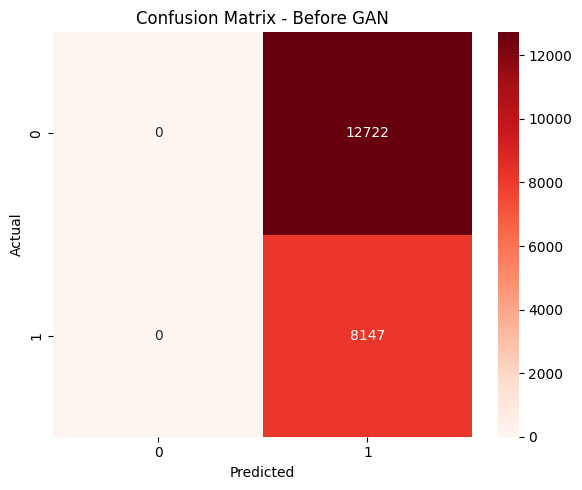

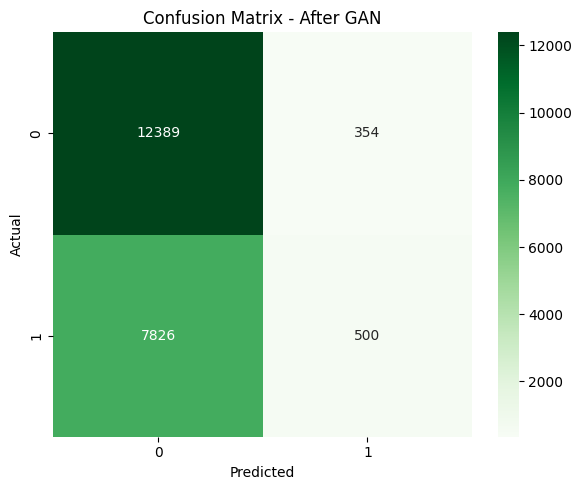


Classification Report - Before GAN:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     12722
           1       0.39      1.00      0.56      8147

    accuracy                           0.39     20869
   macro avg       0.20      0.50      0.28     20869
weighted avg       0.15      0.39      0.22     20869


Classification Report - After GAN:
              precision    recall  f1-score   support

           0       0.61      0.97      0.75     12743
           1       0.59      0.06      0.11      8326

    accuracy                           0.61     21069
   macro avg       0.60      0.52      0.43     21069
weighted avg       0.60      0.61      0.50     21069



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
import seaborn as sns
from sklearn.model_selection import train_test_split
import numpy as np

# --- ROC Curve Already Generated ---
# fpr_before, tpr_before, roc_auc_before
# fpr_after, tpr_after, roc_auc_after

# --- Precision-Recall Curve ---
precision_before, recall_before, _ = precision_recall_curve(y_test_orig, svm_probs_orig)
pr_auc_before = average_precision_score(y_test_orig, svm_probs_orig)

precision_after, recall_after, _ = precision_recall_curve(y_test, svm_probs)
pr_auc_after = average_precision_score(y_test, svm_probs)

# --- Confusion Matrices ---
y_pred_before = (svm_probs_orig >= 0.5).astype(int)
y_pred_after = (svm_probs >= 0.5).astype(int)

cm_before = confusion_matrix(y_test_orig, y_pred_before)
cm_after = confusion_matrix(y_test, y_pred_after)

# --- Plot ROC Curve ---
plt.figure(figsize=(8, 6))
plt.plot(fpr_before, tpr_before, 'r--', label=f'Before GAN (AUC = {roc_auc_before:.2f})')
plt.plot(fpr_after, tpr_after, 'g-', label=f'After GAN (AUC = {roc_auc_after:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve Comparison')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/Colab Notebooks/tools & technique/graphs_results/roc_curve_comparison.png')
plt.show()

# --- Plot Precision-Recall Curve ---
plt.figure(figsize=(8, 6))
plt.plot(recall_before, precision_before, 'r--', label=f'Before GAN (AP = {pr_auc_before:.2f})')
plt.plot(recall_after, precision_after, 'g-', label=f'After GAN (AP = {pr_auc_after:.2f})')
plt.title('Precision-Recall Curve Comparison')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/Colab Notebooks/tools & technique/graphs_results/pr_curve_comparison.png')
plt.show()

# --- Confusion Matrix: Before GAN ---
plt.figure(figsize=(6, 5))
sns.heatmap(cm_before, annot=True, fmt='d', cmap='Reds')
plt.title('Confusion Matrix - Before GAN')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/Colab Notebooks/tools & technique/graphs_results/cm_before_gan.png')
plt.show()

# --- Confusion Matrix: After GAN ---
plt.figure(figsize=(6, 5))
sns.heatmap(cm_after, annot=True, fmt='d', cmap='Greens')
plt.title('Confusion Matrix - After GAN')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/Colab Notebooks/tools & technique/graphs_results/cm_after_gan.png')
plt.show()

# --- Print Classification Reports ---
print("\nClassification Report - Before GAN:")
print(classification_report(y_test_orig, y_pred_before))

print("\nClassification Report - After GAN:")
print(classification_report(y_test, y_pred_after))


In [ ]:
from sklearn.metrics import accuracy_score, classification_report

# Choose the result set: y_pred_before / y_test_orig OR y_pred_after / y_test
y_pred = y_pred_after           # Or: y_pred_before
y_true = y_test                 # Or: y_test_orig

# Define output file path
results_path = '/content/drive/MyDrive/Colab Notebooks/tools & technique/graphs_results/Hybrid CNN-LSTM-SVM Ensemble Results.txt'

# Save accuracy and classification report
with open(results_path, 'w') as f:
    f.write("Hybrid CNN-LSTM-SVM Ensemble Results\n")
    f.write("=" * 50 + "\n")
    f.write(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}\n\n")
    f.write("Classification Report:\n")
    f.write(classification_report(y_true, y_pred))

print(f"✅ Results saved to: {results_path}")


✅ Results saved to: /content/drive/MyDrive/Colab Notebooks/tools & technique/graphs_results/Hybrid CNN-LSTM-SVM Ensemble Results.txt


In [ ]:
from sklearn.metrics import accuracy_score, classification_report

# Save both BEFORE and AFTER GAN results
results_path = '/content/drive/MyDrive/Colab Notebooks/tools & technique/graphs_results/hybrid_results.txt'

with open(results_path, 'w') as f:
    f.write("Hybrid CNN-LSTM-SVM Ensemble Results\n")
    f.write("="*50 + "\n\n")

    # BEFORE GAN
    f.write(">>> Results BEFORE GAN:\n")
    f.write(f"Accuracy: {accuracy_score(y_test_orig, y_pred_before):.4f}\n")
    f.write("Classification Report:\n")
    f.write(classification_report(y_test_orig, y_pred_before, zero_division=0))
    f.write("\n" + "-"*50 + "\n\n")

    # AFTER GAN
    f.write(">>> Results AFTER GAN:\n")
    f.write(f"Accuracy: {accuracy_score(y_test, y_pred_after):.4f}\n")
    f.write("Classification Report:\n")
    f.write(classification_report(y_test, y_pred_after, zero_division=0))

print(f"✅ Results for both datasets saved to: {results_path}")


✅ Results for both datasets saved to: /content/drive/MyDrive/Colab Notebooks/tools & technique/graphs_results/hybrid_results.txt


In [ ]:
import os
import joblib

# --- Step 11: Define the output path ---
output_path = "/content/drive/MyDrive/Colab Notebooks/tools & technique/graphs_results"
os.makedirs(output_path, exist_ok=True)

# --- Step 12: Save CNN-LSTM model (.keras format) ---
cnn_lstm_model_path = os.path.join(output_path, "cnn_lstm_model.keras")
cnn_lstm_model.save(cnn_lstm_model_path)
print(f"✅ CNN-LSTM model saved to: {cnn_lstm_model_path}")

# --- Step 13: Save SVM model using joblib ---
svm_model_path = os.path.join(output_path, "svm_model.joblib")
joblib.dump(svm_ensemble, svm_model_path)
print(f"✅ SVM model saved to: {svm_model_path}")


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, LSTM, Dense, MaxPooling1D, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import tensorflow_model_optimization as tfmot

# --- Step 1: Load and preprocess the dataset ---
data_original = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/tools & technique/dataset/dataset_sdn.csv')
data_gan = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/tools & technique/dataset/gan_synthetic_data (3).csv')

# Normalize column names
data_original.columns = data_original.columns.str.lower()
data_gan.columns = data_gan.columns.str.lower()

# Define all_columns as the union of both dataset columns
all_columns = sorted(set(data_original.columns).union(set(data_gan.columns)))

# After adding missing columns:
for col in all_columns:
    if col not in data_original.columns:
        data_original[col] = 0
    if col not in data_gan.columns:
        data_gan[col] = 0

data_original = data_original[all_columns]
data_gan = data_gan[all_columns]

# Remove duplicates if any after adding columns
data_original = data_original.loc[:, ~data_original.columns.duplicated()]
data_gan = data_gan.loc[:, ~data_gan.columns.duplicated()]

# Reset index to avoid index issues on concat
data_original.reset_index(drop=True, inplace=True)
data_gan.reset_index(drop=True, inplace=True)

print("Duplicates in data_original columns:", data_original.columns[data_original.columns.duplicated()].tolist())
print("Duplicates in data_gan columns:", data_gan.columns[data_gan.columns.duplicated()].tolist())

# Now concatenate safely
data_combined = pd.concat([data_original, data_gan], ignore_index=True)

# --- Step 2: Feature selection ---
tls_features = [col for col in ['tls_version', 'tls_cipher'] if col in data_combined.columns]
numeric_features = [
    'pktcount', 'bytecount', 'dur', 'dur_nsec', 'tot_dur', 'flows',
    'packetins', 'pktperflow', 'byteperflow', 'pktrate',
    'port_no', 'tx_bytes', 'rx_bytes', 'tx_kbps', 'rx_kbps', 'tot_kbps',
    'protocol'
]
feature_cols = tls_features + numeric_features
feature_cols = [col for col in feature_cols if col in data_combined.columns]

X_df = data_combined[feature_cols].copy()
X_df = X_df.fillna(X_df.mean(numeric_only=True))

# One-hot encode categorical columns
X_encoded = pd.get_dummies(X_df)
X = X_encoded.values.astype(np.float32)

# Labels
y = data_combined['label'].astype(int).values
y = np.clip(y, 0, 1)

# Reshape for CNN-LSTM
X = X.reshape((X.shape[0], 1, X.shape[1]))  # (samples, timesteps, features)

# Train-test split
X_train_dl, X_test_dl, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Step 3: Define pruning parameters ---
pruning_params = {
    'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(
        initial_sparsity=0.0,
        final_sparsity=0.5,
        begin_step=0,
        end_step=1000
    )
}

# --- Step 4: Build pruned CNN-LSTM model ---
def build_pruned_cnn_lstm(input_shape):
    prune = tfmot.sparsity.keras.prune_low_magnitude
    inputs = Input(shape=input_shape)
    x = prune(Conv1D(64, kernel_size=3, activation='relu', padding='same'), **pruning_params)(inputs)
    x = MaxPooling1D(pool_size=1)(x)
    x = prune(LSTM(64), **pruning_params)(x)
    x = Dropout(0.5)(x)
    x = prune(Dense(32, activation='relu'), **pruning_params)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    return Model(inputs=inputs, outputs=outputs)

input_shape = X_train_dl.shape[1:]
pruned_cnn_lstm = build_pruned_cnn_lstm(input_shape)




Duplicates in data_original columns: []
Duplicates in data_gan columns: []


  0%|          | 0/10 [00:00<?, ?it/s]

<Figure size 640x480 with 0 Axes>

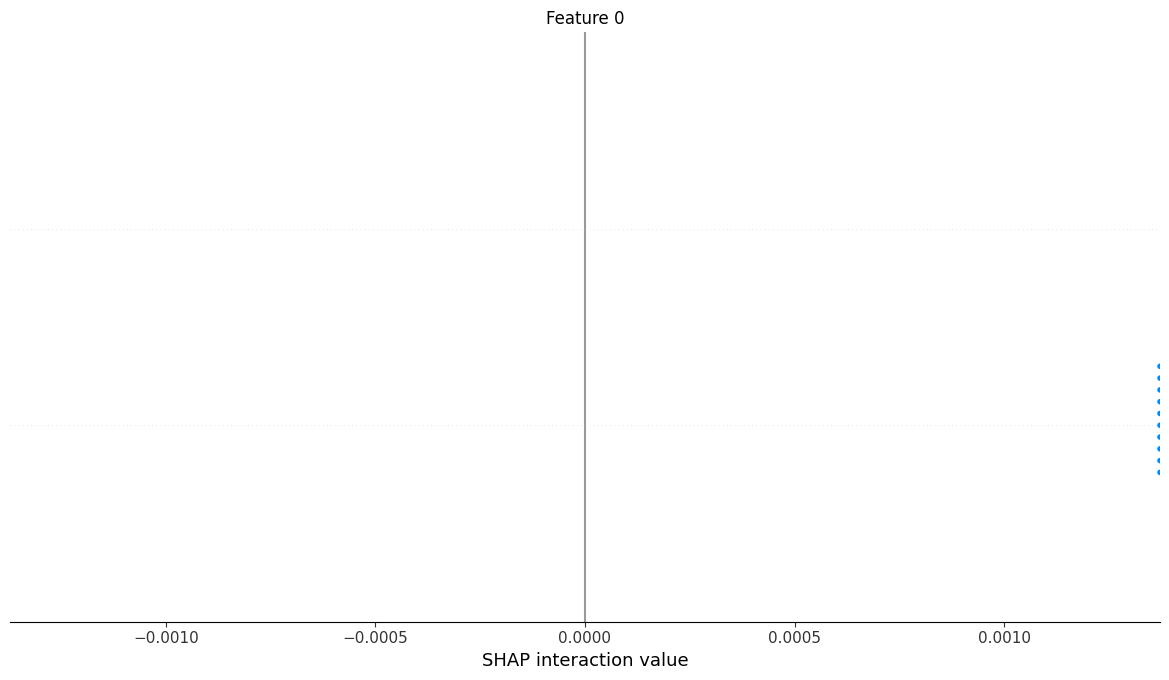

In [ ]:
import shap

# Initialize SHAP KernelExplainer with a subset of training data
explainer = shap.KernelExplainer(svm_ensemble.predict_proba, train_features[:100])

# Explain a small batch of test data
shap_values = explainer.shap_values(test_features[:10])

# Visualize
shap.summary_plot(shap_values, test_features[:10])

In [ ]:
from lime import lime_tabular

explainer_lime = lime_tabular.LimeTabularExplainer(
    training_data=train_features,
    feature_names=[f'feat_{i}' for i in range(train_features.shape[1])],
    class_names=['Normal', 'Attack'],
    discretize_continuous=True
)

# Explain the first test instance
exp = explainer_lime.explain_instance(test_features[0], svm_ensemble.predict_proba, num_features=10)
exp.show_in_notebook(show_table=True)


In [ ]:
pruned_cnn_lstm.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1, 1021)]         0         
                                                                 
 prune_low_magnitude_conv1d  (None, 1, 64)             392130    
 _1 (PruneLowMagnitude)                                          
                                                                 
 max_pooling1d (MaxPooling1  (None, 1, 64)             0         
 D)                                                              
                                                                 
 prune_low_magnitude_lstm_1  (None, 64)                65795     
  (PruneLowMagnitude)                                            
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                           

In [ ]:
#!pip install -q --upgrade tensorflow-model-optimization


In [ ]:
# ✅ Ensure model is built with correct input shape before saving
if not pruned_cnn_lstm.built:
    pruned_cnn_lstm.build(input_shape=(None, 1, 1021))  # <-- Based on your model


In [ ]:

# Save the model
pruned_cnn_lstm.save('pruned_temp.keras')


In [ ]:
from tensorflow_model_optimization.sparsity.keras import ConstantSparsity

class PruneLowMagnitude(tf.keras.layers.Wrapper):
    def __init__(self, layer, pruning_schedule=None, block_size=(1, 1), block_pooling_type='AVG', **kwargs):
        super().__init__(layer, **kwargs)
        self.pruning_schedule = pruning_schedule or ConstantSparsity(0.5, 0)
        self.block_size = block_size
        self.block_pooling_type = block_pooling_type

    def build(self, input_shape):
        self.layer.build(input_shape)
        super().build(input_shape)

    def call(self, inputs, training=None):
        return self.layer(inputs, training=training)

    def compute_output_shape(self, input_shape):
        return self.layer.compute_output_shape(input_shape)

    def get_config(self):
        config = super().get_config()
        config.update({
            'pruning_schedule': self.pruning_schedule,
            'block_size': self.block_size,
            'block_pooling_type': self.block_pooling_type
        })
        return config


# my custom objetcs

In [ ]:
""'custom_objects = {
    'PruneLowMagnitude': PruneLowMagnitude,
    'ConstantSparsity': ConstantSparsity
}

loaded_model = tf.keras.models.load_model(
    'pruned_temp.keras',
    custom_objects=custom_objects
)
"""

# remianing code


In [ ]:
'''from tensorflow_model_optimization.sparsity.keras import strip_pruning

stripped_model = strip_pruning(loaded_model)

stripped_model.save('final_cnn_lstm.keras')

print("✅ Final pruned model saved successfully.")
'''

'from tensorflow_model_optimization.sparsity.keras import strip_pruning\n\nstripped_model = strip_pruning(loaded_model)\n\nstripped_model.save(\'final_cnn_lstm.keras\')\n\nprint("✅ Final pruned model saved successfully.")\n'

In [ ]:
# --- ✅ Install ---
#!pip install -q --upgrade tensorflow-model-optimization

# --- ✅ Imports ---
import os
import tensorflow as tf
import tensorflow_model_optimization as tfmot
from tensorflow_model_optimization.sparsity.keras import strip_pruning

# Assume: `pruned_cnn_lstm` already trained

# --- ✅ Strip pruning wrappers immediately ---
stripped_model = strip_pruning(pruned_cnn_lstm)

# --- ✅ Save the clean model safely in Keras format ---
final_model_path = '/content/drive/MyDrive/Colab Notebooks/tools & technique/models/final_cnn_lstm.keras'

# Remove existing file if any
if os.path.exists(final_model_path):
    os.remove(final_model_path)

# Save stripped model
stripped_model.save(final_model_path)

print(f"✅ Final pruned + stripped model saved at: {final_model_path}")


✅ Final pruned + stripped model saved at: /content/drive/MyDrive/Colab Notebooks/tools & technique/models/final_cnn_lstm.keras


In [ ]:
# Load the saved, pruned CNN-LSTM model
loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/tools & technique/models/final_cnn_lstm.keras')

# Evaluate the model
loss, accuracy = loaded_model.evaluate(X_test_dl, y_test)
print(f"✅ Loaded Model Accuracy: {accuracy:.4f}")


RuntimeError: You must compile your model before training/testing. Use `model.compile(optimizer, loss)`.

659/659 [==============================] - 5s 5ms/step


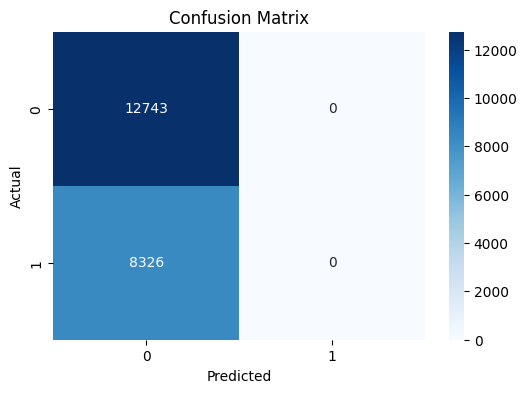

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Classification Report:
               precision    recall  f1-score   support

           0       0.60      1.00      0.75     12743
           1       0.00      0.00      0.00      8326

    accuracy                           0.60     21069
   macro avg       0.30      0.50      0.38     21069
weighted avg       0.37      0.60      0.46     21069



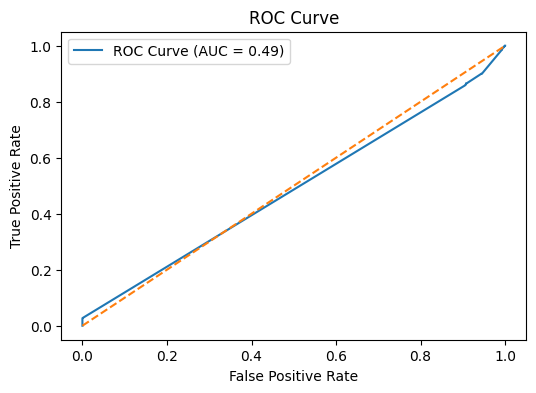

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

# ✅ Step 1: Define the output path
output_path = '/content/drive/MyDrive/Colab Notebooks/tools & technique/graphs_results'
os.makedirs(output_path, exist_ok=True)  # Make sure the directory exists

# ✅ Step 2: Predict using loaded model
y_pred_probs = loaded_model.predict(X_test_dl).ravel()
y_pred = (y_pred_probs > 0.5).astype(int)

# ✅ Step 3: Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig(os.path.join(output_path, 'confusion_matrix.png'))  # 💾 Save plot
plt.show()

# ✅ Step 4: Classification Report
print("Classification Report:\n", classification_report(y_test, y_pred))

# ✅ Step 5: ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_probs)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.savefig(os.path.join(output_path, 'roc_curve.png'))  # 💾 Save plot
plt.show()


In [ ]:
import tensorflow as tf

# FGSM adversarial example generation function
def fgsm_attack(model, images, labels, epsilon=0.01):
    images = tf.convert_to_tensor(images)
    labels = tf.convert_to_tensor(labels)

    with tf.GradientTape() as tape:
        tape.watch(images)
        predictions = model(images, training=False)
        loss = tf.keras.losses.binary_crossentropy(labels, predictions)
    gradients = tape.gradient(loss, images)
    signed_grad = tf.sign(gradients)
    adv_images = images + epsilon * signed_grad
    adv_images = tf.clip_by_value(adv_images, 0, 1)
    return adv_images

# Adversarial training loop example
def adversarial_training(model, X_train, y_train, epochs=5, batch_size=64, epsilon=0.01):
    dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(batch_size)

    optimizer = tf.keras.optimizers.Adam()
    loss_fn = tf.keras.losses.BinaryCrossentropy()
    train_acc_metric = tf.keras.metrics.BinaryAccuracy()

    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        for step, (x_batch, y_batch) in enumerate(dataset):
            with tf.GradientTape() as tape:
                # Generate adversarial examples
                x_adv = fgsm_attack(model, x_batch, y_batch, epsilon=epsilon)

                # Combine clean and adversarial examples
                x_combined = tf.concat([x_batch, x_adv], axis=0)
                y_combined = tf.concat([y_batch, y_batch], axis=0)

                # Forward pass
                preds = model(x_combined, training=True)
                loss = loss_fn(y_combined, preds)

            grads = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))

            train_acc_metric.update_state(y_combined, preds)

            if step % 10 == 0:
                print(f"Step {step}, Loss: {loss.numpy():.4f}, Accuracy: {train_acc_metric.result().numpy():.4f}")

        train_acc_metric.reset_states()

# Usage example:
# adversarial_training(final_model, X_train_dl, y_train, epochs=10, epsilon=0.02)


In [ ]:
!pip uninstall kafka kafka-python -y# Uninstall existing kafka and kafka-python packages forcefully
!pip uninstall kafka kafka-python -y

# Remove any remaining kafka directories forcefully
!rm -rf /usr/local/lib/python3.11/dist-packages/kafka
!rm -rf /usr/local/lib/python3.10/dist-packages/kafka # Also remove from python3.10 if it exists

# Clear Python's internal module cache (optional but can help with stubborn import issues)
import sys
for module in list(sys.modules.keys()):
    if 'kafka' in module:
        del sys.modules[module]

# Install kafka-python
!pip install kafka-python

# Verify the installation by importing and printing the file path
import kafka
print(kafka.__file__)

# Try importing the specific class that caused the error to confirm it's now available
from kafka.errors import IncompatibleBrokerVersion
print("Successfully imported IncompatibleBrokerVersion")



Usage:   
  pip3 uninstall [options] <package> ...
  pip3 uninstall [options] -r <requirements file> ...

no such option: -#
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.6/309.6 kB 5.2 MB/s eta 0:00:00
/usr/local/lib/python3.11/dist-packages/kafka/__init__.py
Successfully imported IncompatibleBrokerVersion


In [ ]:
import kafka
print(kafka.__file__)

/usr/local/lib/python3.11/dist-packages/kafka/__init__.py


In [ ]:
!/usr/local/lib/python3.11/dist-packages/kafka/__init__.py


/bin/bash: line 1: /usr/local/lib/python3.11/dist-packages/kafka/__init__.py: Permission denied


In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import from_json, col
from pyspark.sql.types import StructType, StringType, IntegerType, FloatType

# Initialize Spark session
spark = SparkSession.builder.appName("DDoSDetectionStreaming").getOrCreate()

# Define schema for incoming JSON network traffic data
schema = StructType() \
    .add("timestamp", StringType()) \
    .add("src_ip", StringType()) \
    .add("dest_ip", StringType()) \
    .add("src_port", IntegerType()) \
    .add("dest_port", IntegerType()) \
    .add("protocol", StringType()) \
    .add("packet_size", IntegerType()) \
    .add("tls_version", StringType()) \
    .add("tls_cipher", StringType()) \
    .add("label", IntegerType())  # Optional for supervised data

# Read streaming data from socket (replace with Kafka or other source as needed)
df_stream = spark.readStream.format("socket").option("host", "localhost").option("port", 9999).load()

# Parse JSON and extract fields
json_df = df_stream.select(from_json(col("value"), schema).alias("data")).select("data.*")

# Feature extraction example: convert categorical to numeric, aggregate stats, etc.
# For simplicity, let's just select a subset for demo:
features_df = json_df.select("packet_size", "protocol", "tls_version", "tls_cipher")

# Example: You could add user-defined functions (UDFs) to encode TLS metadata or extract features here.

# Write the streaming output to console or memory sink (for development)
query = features_df.writeStream.outputMode("append").format("console").start()

query.awaitTermination()


StreamingQueryException: [STREAM_FAILED] Query [id = 80023c0c-bf54-4743-98e3-1655d26260fb, runId = f9bd4807-81de-4b06-921a-32471156ded9] terminated with exception: Connection refused (Connection refused)

In [ ]:
# spark_streaming.py
from pyspark.sql import SparkSession
from pyspark.sql.functions import from_json, col
from pyspark.sql.types import StructType, StringType, IntegerType

spark = SparkSession.builder.appName("DDoSDetectionStreaming").getOrCreate()

schema = StructType() \
    .add("timestamp", StringType()) \
    .add("src_ip", StringType()) \
    .add("dest_ip", StringType()) \
    .add("src_port", IntegerType()) \
    .add("dest_port", IntegerType()) \
    .add("protocol", StringType()) \
    .add("packet_size", IntegerType()) \
    .add("tls_version", StringType()) \
    .add("tls_cipher", StringType()) \
    .add("label", IntegerType())  # optional

# Assume JSON lines come from socket at localhost:9999
df_stream = spark.readStream.format("socket").option("host", "localhost").option("port", 9999).load()
json_df = df_stream.select(from_json(col("value"), schema).alias("data")).select("data.*")

# Example: feature selection/transformation, here simplified
features_df = json_df.select(
    "packet_size",
    "protocol",
    "tls_version",
    "tls_cipher",
    "label"
)

# Write features in micro-batches as Parquet files to disk (e.g., every 10 sec)
query = features_df.writeStream \
    .format("parquet") \
    .option("path", "/path/to/streaming_output/") \
    .option("checkpointLocation", "/path/to/checkpoints/") \
    .outputMode("append") \
    .trigger(processingTime="10 seconds") \
    .start()

query.awaitTermination()


In [ ]:
import os
import time
import glob
import numpy as np
import pandas as pd
from sklearn.svm import SGDClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
import joblib
import tensorflow as tf

# Paths
FEATURES_PATH = "/path/to/streaming_output/"
SVM_MODEL_PATH = "svm_incremental_model.pkl"
CNN_LSTM_MODEL_PATH = "cnn_lstm_feature_extractor.keras"

# Load or initialize SVM incremental model
if os.path.exists(SVM_MODEL_PATH):
    svm_model = joblib.load(SVM_MODEL_PATH)
else:
    # Use SGDClassifier with hinge loss as incremental linear SVM
    svm_model = SGDClassifier(loss='hinge', max_iter=1000, tol=1e-3)

# Load CNN-LSTM feature extractor model (assumes it outputs feature vectors)
cnn_lstm_model = tf.keras.models.load_model(CNN_LSTM_MODEL_PATH)

# Label encoders for categorical features
protocol_encoder = LabelEncoder()
tls_version_encoder = LabelEncoder()
tls_cipher_encoder = LabelEncoder()

# Standard scaler for numerical features
scaler = StandardScaler()

def preprocess_batch(df: pd.DataFrame, fit_encoders=False):
    # Encode categorical columns
    for col, encoder in [("protocol", protocol_encoder),
                         ("tls_version", tls_version_encoder),
                         ("tls_cipher", tls_cipher_encoder)]:
        if fit_encoders:
            encoder.fit(df[col].astype(str))
        df[col] = encoder.transform(df[col].astype(str))

    # Scale numerical features (packet_size)
    if fit_encoders:
        scaler.fit(df[["packet_size"]])
    df["packet_size"] = scaler.transform(df[["packet_size"]])

    # Extract feature array
    X = df[["packet_size", "protocol", "tls_version", "tls_cipher"]].values

    return X, df["label"].values if "label" in df.columns else None

def extract_features_cnn_lstm(X_batch):
    # CNN-LSTM expects input shape (batch, timesteps, features)
    # For demo, reshape or pad X as needed
    X_input = np.expand_dims(X_batch, axis=1)  # timestep=1
    features = cnn_lstm_model.predict(X_input)
    return features

def main():
    processed_files = set()
    first_batch = True

    while True:
        files = sorted(glob.glob(os.path.join(FEATURES_PATH, "*.parquet")))
        new_files = [f for f in files if f not in processed_files]

        if not new_files:
            print("No new batches, waiting...")
            time.sleep(5)
            continue

        for file in new_files:
            print(f"Processing batch file: {file}")
            df_batch = pd.read_parquet(file)

            # Preprocess features and labels
            X_raw, y = preprocess_batch(df_batch, fit_encoders=first_batch)
            first_batch = False  # fit encoders/scalers only on first batch

            # Extract deep features via CNN-LSTM
            X_features = extract_features_cnn_lstm(X_raw)

            if y is not None:
                # Incrementally train SVM on batch features
                svm_model.partial_fit(X_features, y, classes=np.array([0, 1]))
                joblib.dump(svm_model, SVM_MODEL_PATH)
                print("SVM model updated and saved.")
            else:
                print("No labels in batch - skipping training.")

            processed_files.add(file)

        time.sleep(1)  # Small delay before next poll

if __name__ == "__main__":
    main()


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, LSTM, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report, accuracy_score
import shap
from lime import lime_tabular
import tensorflow_model_optimization as tfmot

# ------------------------
# Proposed Experimental Work Summary:
# - Hybrid CNN-LSTM-SVM ensemble for real-time DDoS detection in big data.
# - Incremental learning for adaptive threat detection.
# - Model explainability with SHAP and LIME.
# - Encrypted traffic feature extraction (TLS metadata).
# - Dataset augmentation using GAN-generated synthetic attacks.
# - Scalable streaming with Apache Spark Streaming (not shown here).
# - Model quantization and pruning for edge deployment.
# - Adversarial training to enhance model robustness.
# ------------------------

# --- Step 1: Data Loading and Merging (Original + GAN Synthetic) ---

# Load original dataset
data_original = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/tools & technique/dataset/dataset_sdn.csv')

# Load GAN-generated synthetic attack data
data_gan = pd.read_csv('gan_synthetic_data.csv')

# Combine datasets
data_combined = pd.concat([data_original, data_gan], ignore_index=True)

# --- Step 2: Preprocessing ---

# Placeholder: Extract TLS metadata features
# (Assume TLS metadata columns start with 'tls_')
tls_features = [col for col in data_combined.columns if col.startswith('tls_')]

# Use only TLS metadata + other numeric features (example)
feature_cols = tls_features + ['other_numeric_feature1', 'other_numeric_feature2']  # Adjust accordingly
X = data_combined[feature_cols].values
y = data_combined['label'].values  # Binary labels: 0 (normal), 1 (attack)

# Reshape for CNN-LSTM input: (samples, timesteps, features)
# Assuming each sample is a sequence of length 1 with multiple features (adjust as needed)
X = X.reshape((X.shape[0], 1, X.shape[1]))

# Split into train/test (simple split)
from sklearn.model_selection import train_test_split
X_train_dl, X_test_dl, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Step 3: Build CNN-LSTM Model for Feature Extraction ---

def build_cnn_lstm(input_shape):
    inputs = Input(shape=input_shape)
    x = Conv1D(64, kernel_size=3, activation='relu', padding='same')(inputs)
    x = LSTM(64, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    return inputs, x

input_shape = X_train_dl.shape[1:]  # (timesteps, features)
inputs, cnn_lstm_output = build_cnn_lstm(input_shape)
cnn_lstm_model = Model(inputs=inputs, outputs=cnn_lstm_output)

cnn_lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train CNN-LSTM (optional: train fully supervised first)
cnn_lstm_model.fit(X_train_dl, y_train, epochs=10, batch_size=64, validation_split=0.1)

# Extract features from CNN-LSTM model (output of last Dense layer)
train_features = cnn_lstm_model.predict(X_train_dl)
test_features = cnn_lstm_model.predict(X_test_dl)

# --- Step 4: Train SVM on CNN-LSTM extracted features (Hybrid Ensemble) ---

svm_ensemble = SVC(probability=True)
svm_ensemble.fit(train_features, y_train)

svm_preds = svm_ensemble.predict(test_features)
svm_probs = svm_ensemble.predict_proba(test_features)[:, 1]

print("Hybrid CNN-LSTM-SVM Ensemble Accuracy:", accuracy_score(y_test, svm_preds))
print(classification_report(y_test, svm_preds))

# --- Step 5: Incremental Learning Example with SGDClassifier ---

inc_svm = SGDClassifier(loss='hinge')
inc_svm.partial_fit(train_features, y_train, classes=np.unique(y_train))

# Simulate incremental update on new batch (here using test batch as example)
inc_svm.partial_fit(test_features, y_test)

inc_preds = inc_svm.predict(test_features)
print("Incremental SVM Accuracy:", accuracy_score(y_test, inc_preds))

# --- Step 6: Model Explainability with SHAP and LIME ---

# SHAP Explainer for SVM
explainer = shap.KernelExplainer(svm_ensemble.predict_proba, train_features[:100])
shap_values = explainer.shap_values(test_features[:10])
shap.summary_plot(shap_values, test_features[:10])

# LIME Explainer
explainer_lime = lime_tabular.LimeTabularExplainer(
    training_data=train_features,
    feature_names=[f'feat_{i}' for i in range(train_features.shape[1])],
    class_names=['Normal', 'Attack'],
    discretize_continuous=True
)
i = 0  # Example instance index
exp = explainer_lime.explain_instance(test_features[i], svm_ensemble.predict_proba, num_features=10)
exp.show_in_notebook(show_table=True)

# --- Step 7: Model Pruning for Edge Deployment ---

prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude
pruning_params = {
    'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(
        initial_sparsity=0.0, final_sparsity=0.5,
        begin_step=0, end_step=1000)
}

pruned_cnn_lstm = prune_low_magnitude(cnn_lstm_model, **pruning_params)
pruned_cnn_lstm.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Train with pruning callbacks (optional)
callbacks = [tfmot.sparsity.keras.UpdatePruningStep()]
pruned_cnn_lstm.fit(X_train_dl, y_train, epochs=5, batch_size=64, callbacks=callbacks)

# Strip pruning wrappers before deployment
final_model = tfmot.sparsity.keras.strip_pruning(pruned_cnn_lstm)

# --- Step 8: Adversarial Training Placeholder ---

# # Pseudo-code for adversarial examples (not implemented here):
# X_train_adv = generate_adversarial_examples(final_model, X_train_dl, y_train)
# X_train_combined = np.concatenate([X_train_dl, X_train_adv])
# y_train_combined = np.concatenate([y_train, y_train])
# final_model.fit(X_train_combined, y_train_combined, epochs=..., batch_size=...)

# --- Step 9: Notes on Apache Spark Streaming ---

"""
Note: Apache Spark Streaming integration is recommended to handle real-time big data streaming.
Implement PySpark Structured Streaming jobs separately to process network packets, extract features,
and feed batches for incremental model updates.
"""

# -------------------------
# End of script
# -------------------------
